In [14]:
import glob

import matplotlib.pyplot as plt
import pandas as pd

In [15]:
all_csv_files = glob.glob("results/*.csv")

### Plot train loss for all full precision models


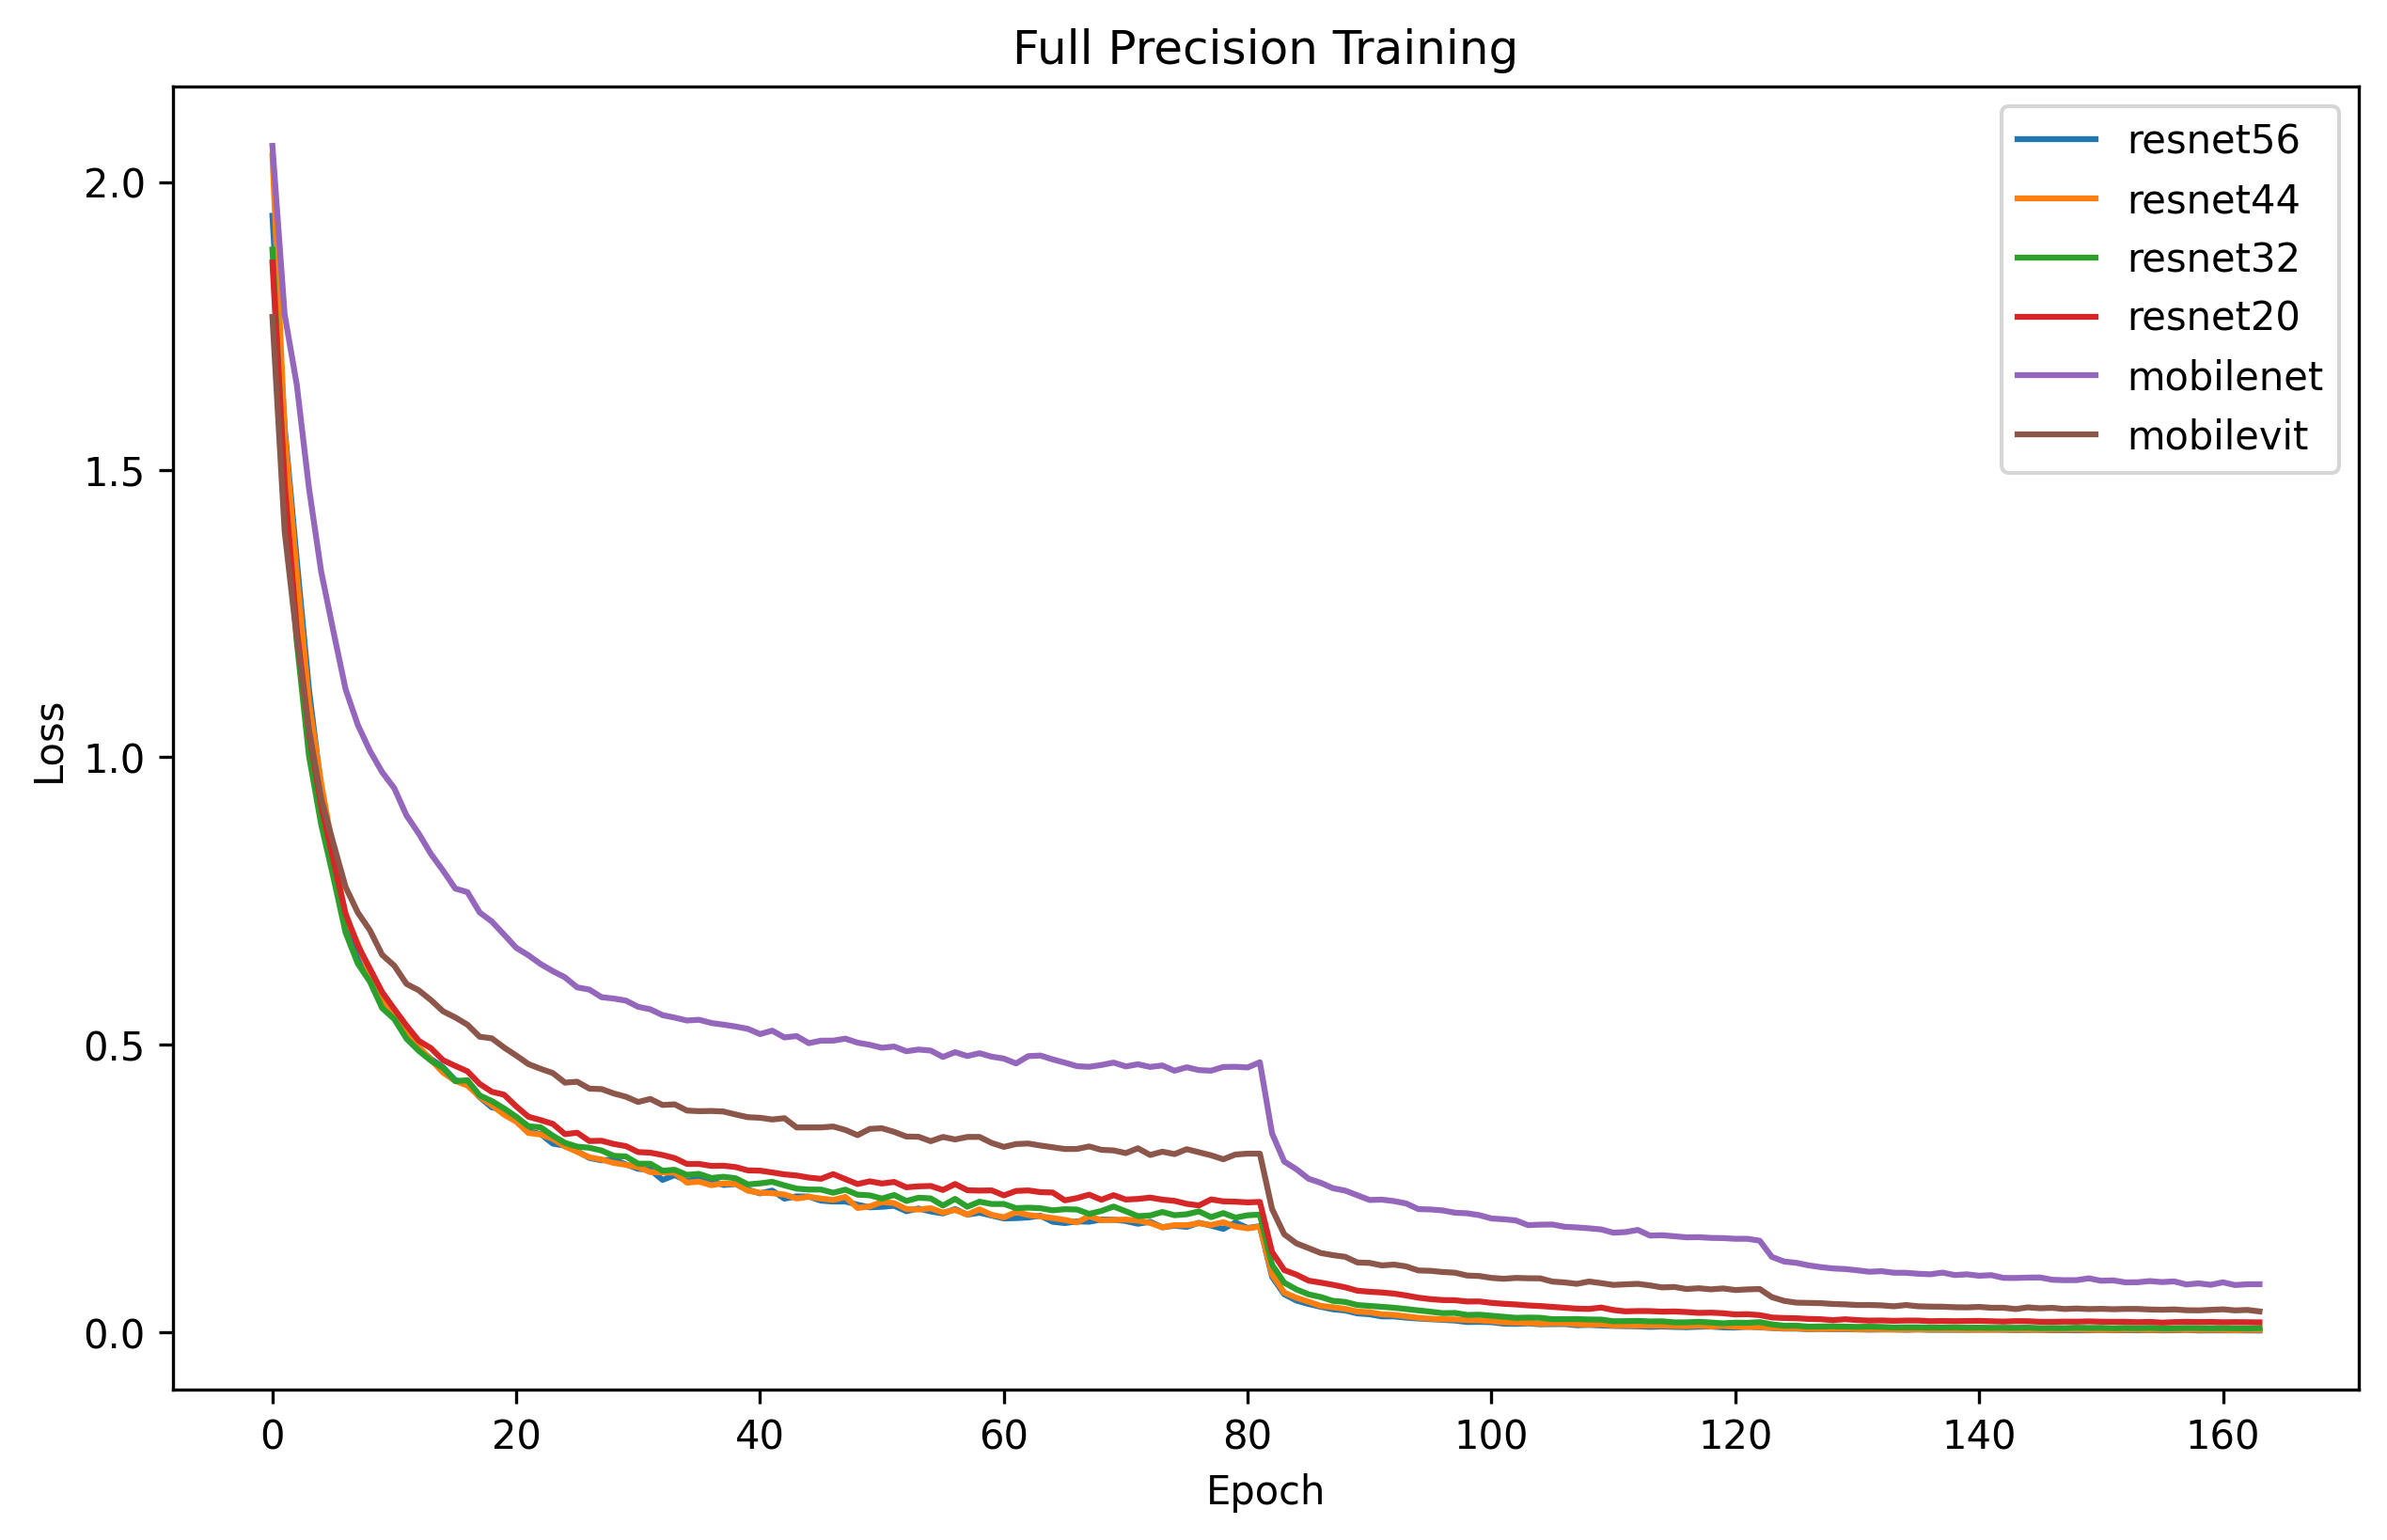

In [28]:
def plot_full_precision_training(metric: str, ylabel: str):
    dfs = []
    for csv_file in [csv_file for csv_file in all_csv_files if "precision" in csv_file]:
        df = pd.read_csv(csv_file)
        model_name = csv_file.split("/")[-1].split("_")[0]
        dfs.append((model_name, df))

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    for model_name, df in dfs:
        ax.plot(df["epoch"], df[metric], label=model_name)

    ax.set_title("Full Precision Training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.show()


plot_full_precision_training("train_loss", "Loss")

### Plot train accuracy for all full precision models


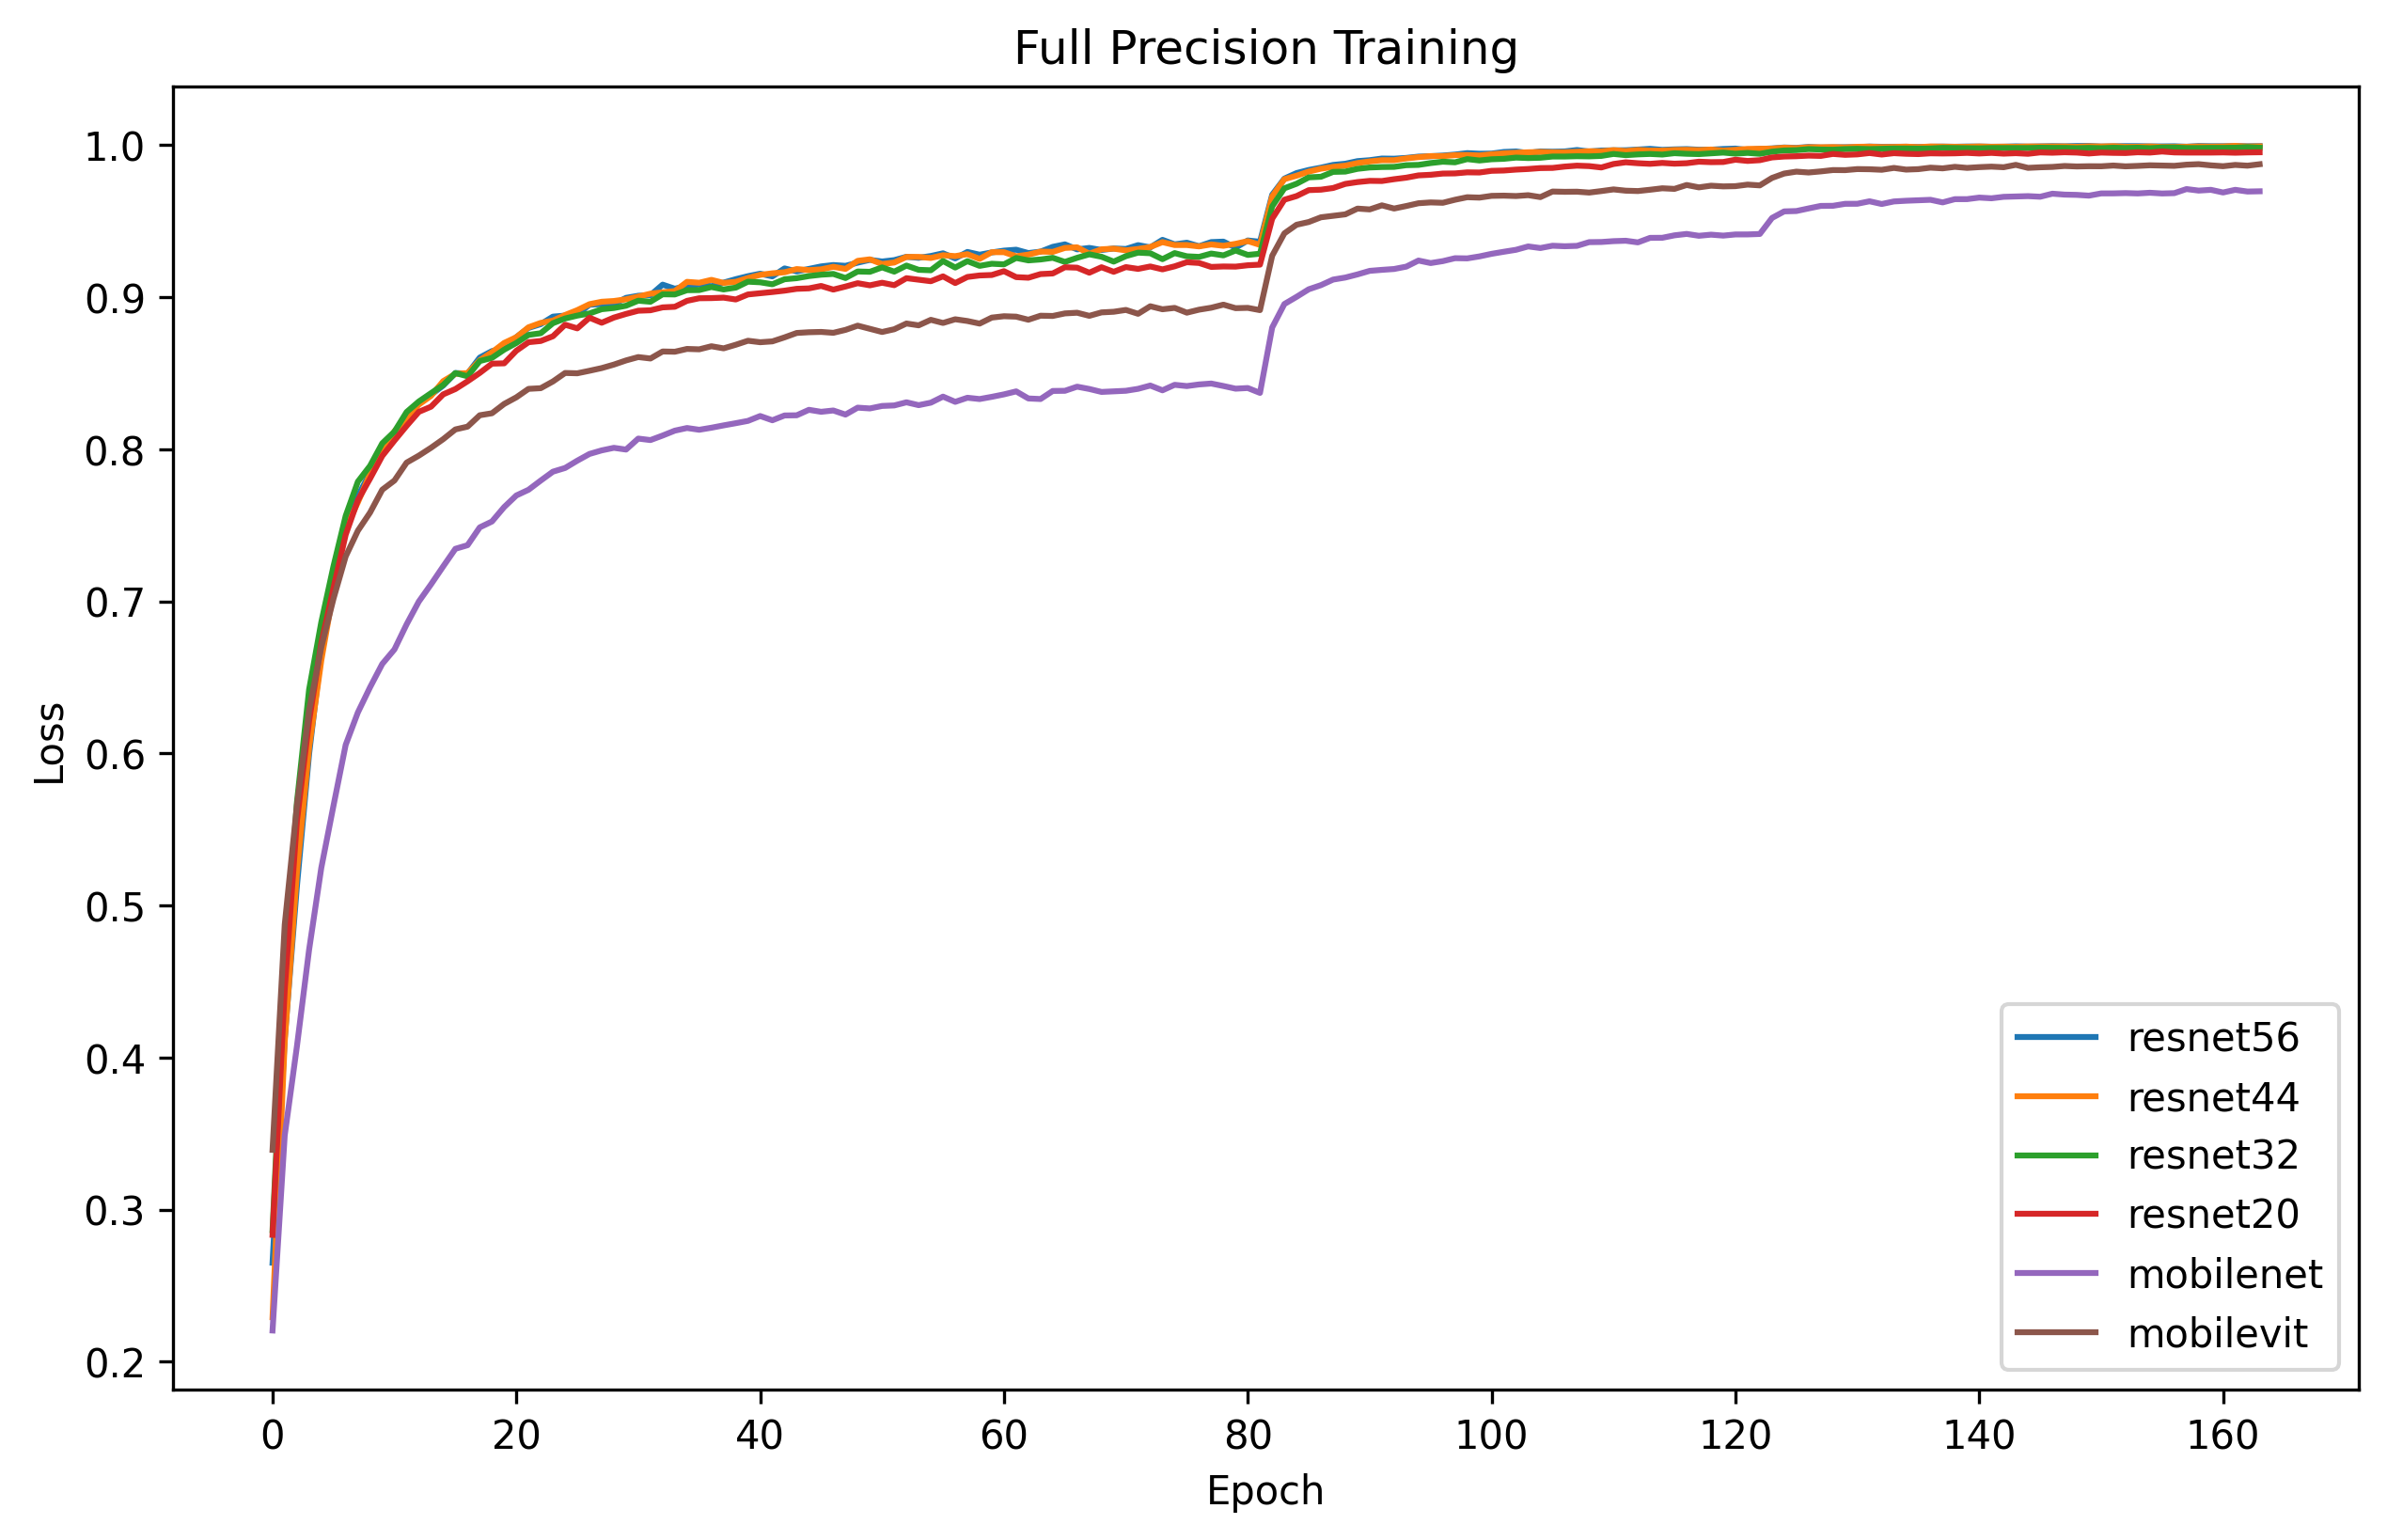

In [29]:
plot_full_precision_training("train_acc", "Loss")

### Plot train loss for QAT ResNet20


In [46]:
def plot_qat_training(metric: str, ylabel: str, model_name: str):
    dfs = []
    for csv_file in [
        csv_file
        for csv_file in all_csv_files
        if model_name in csv_file
        and "precision" not in csv_file
        and "_results" not in csv_file
    ]:
        df = pd.read_csv(csv_file)
        label = "_".join(csv_file.split("/")[-1].split("_")[2:4])
        dfs.append((label, df))

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    color_map = {
        "po2": "red",
        "po2+": "orange",
        "lin": "blue",
        "lin+": "purple",
    }

    for label, df in dfs:
        color = color_map[label.split("_")[0]]
        ax.plot(df["epoch"], df[metric], label=label, color=color)

    ax.set_title(f"Quantize Aware Training: {model_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.show()

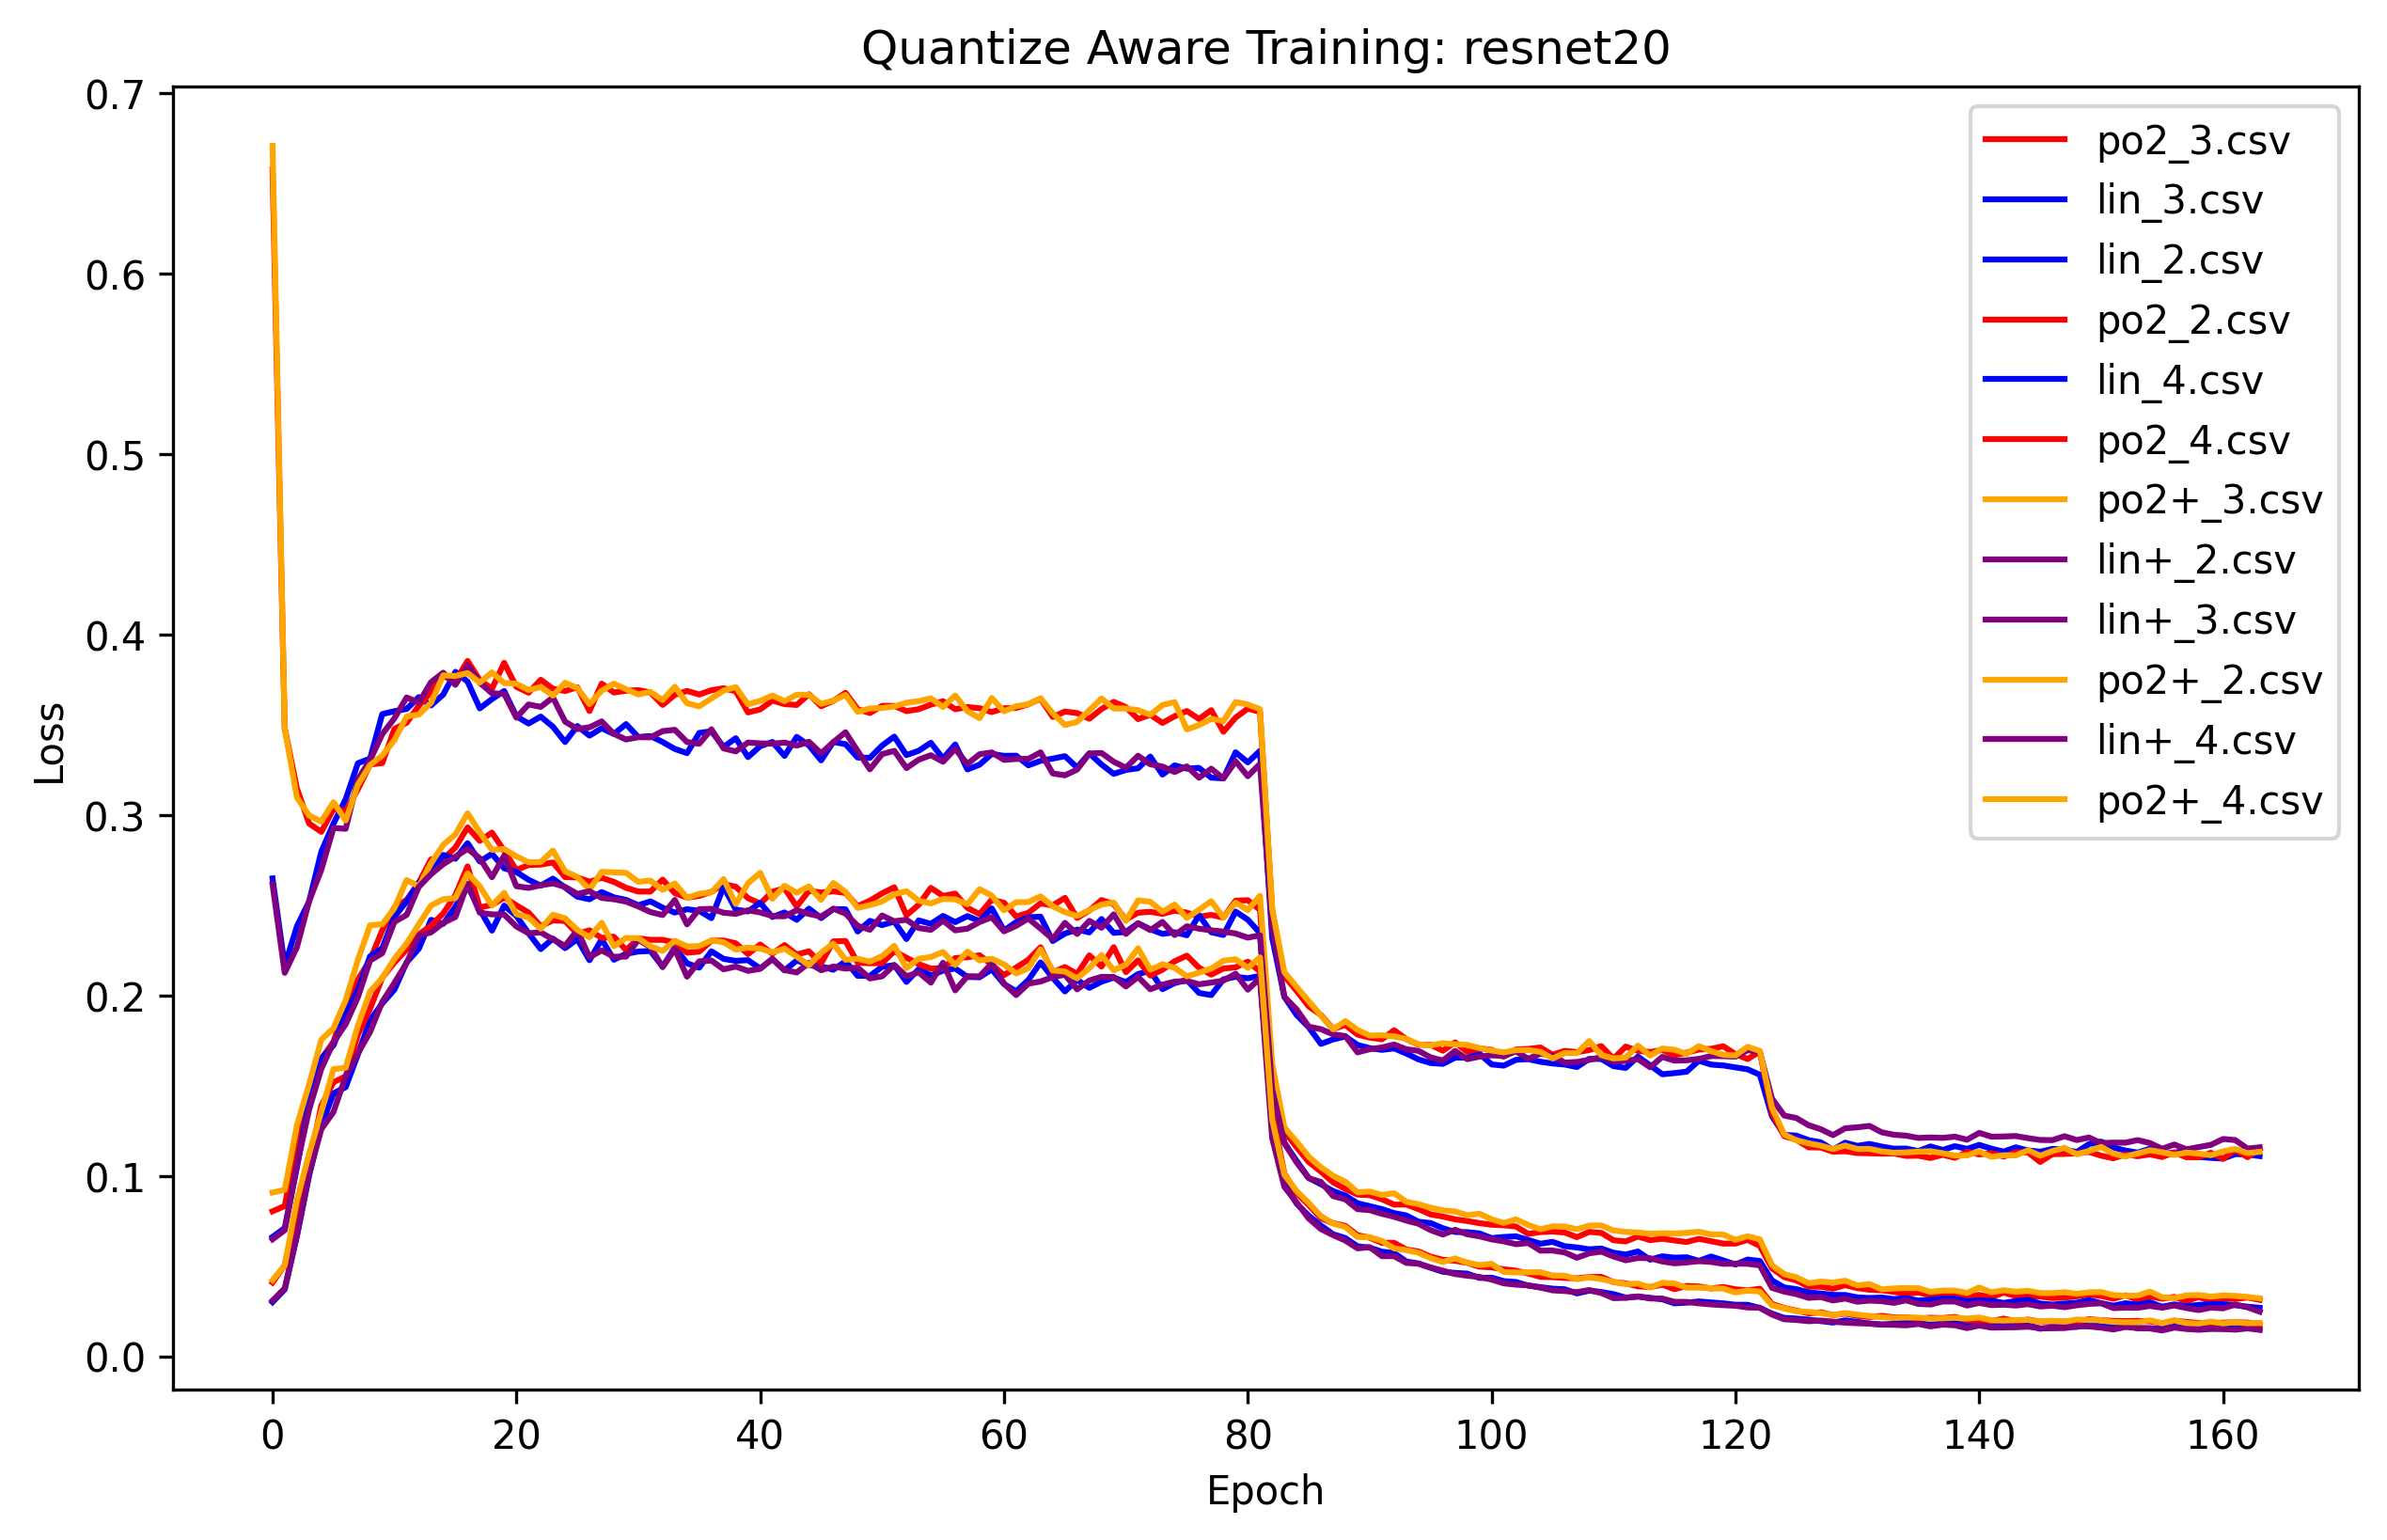

In [47]:
plot_qat_training("train_loss", "Loss", "resnet20")

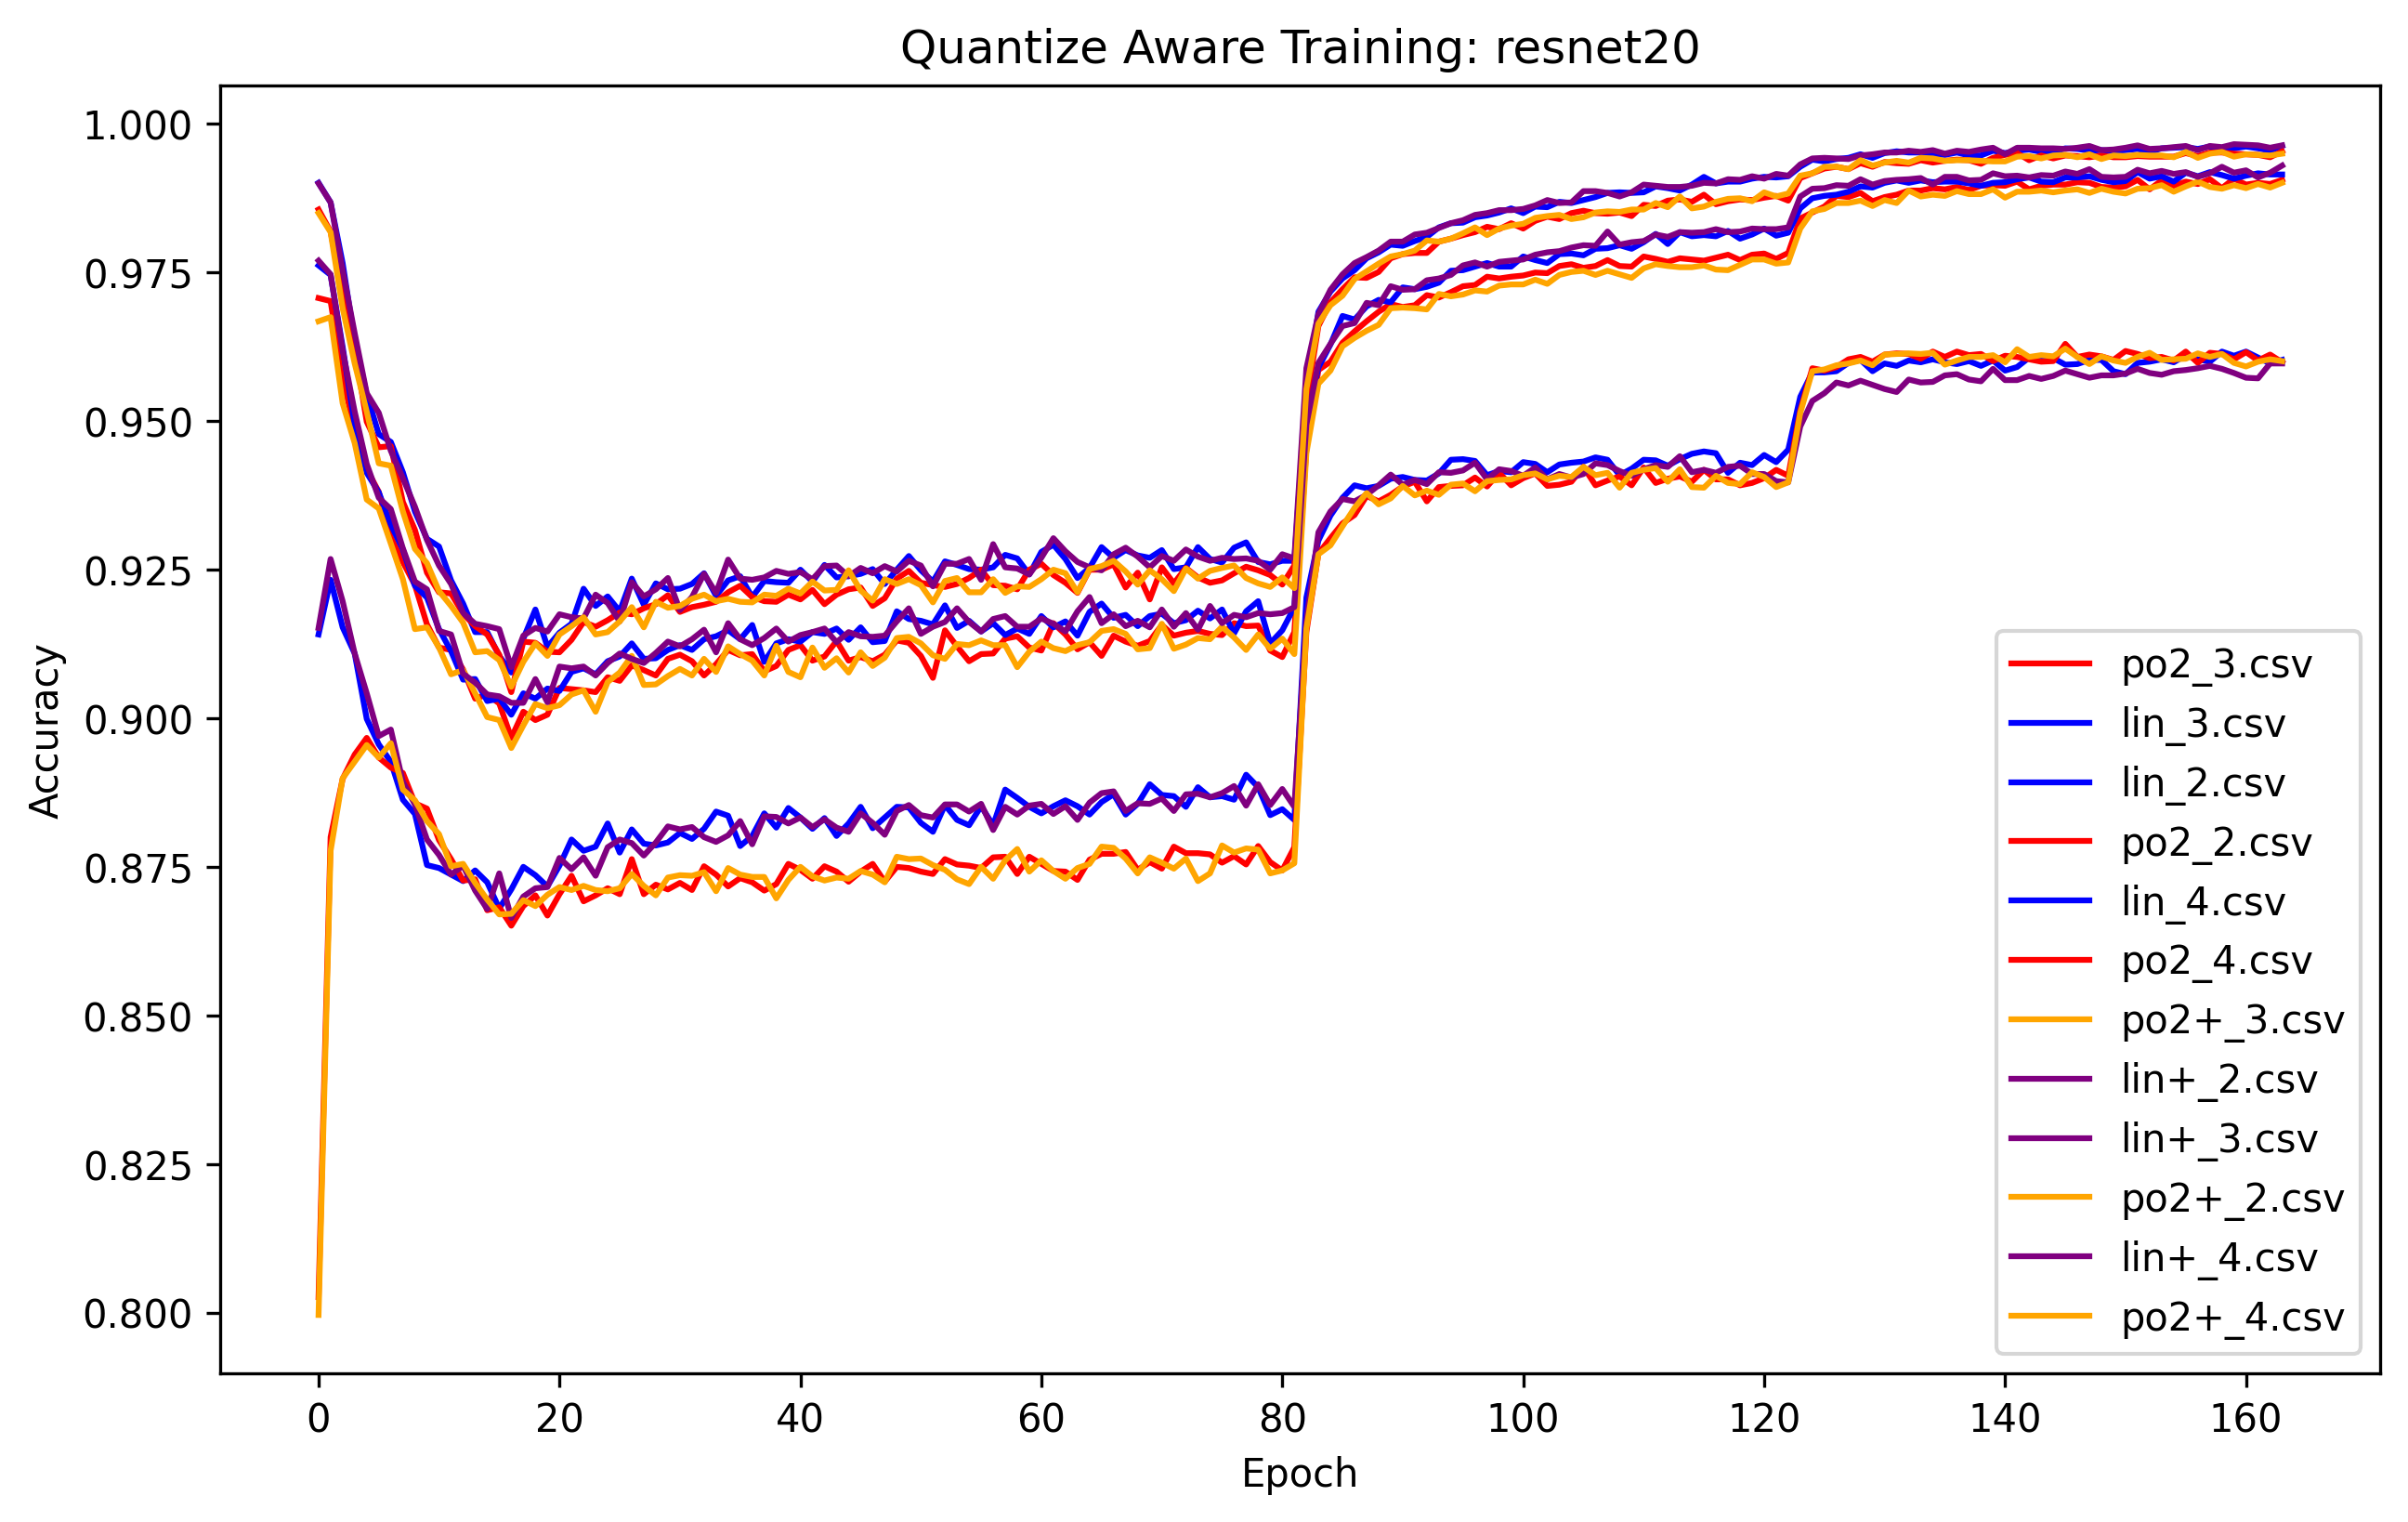

In [55]:
plot_qat_training("train_acc", "Accuracy", "resnet20")

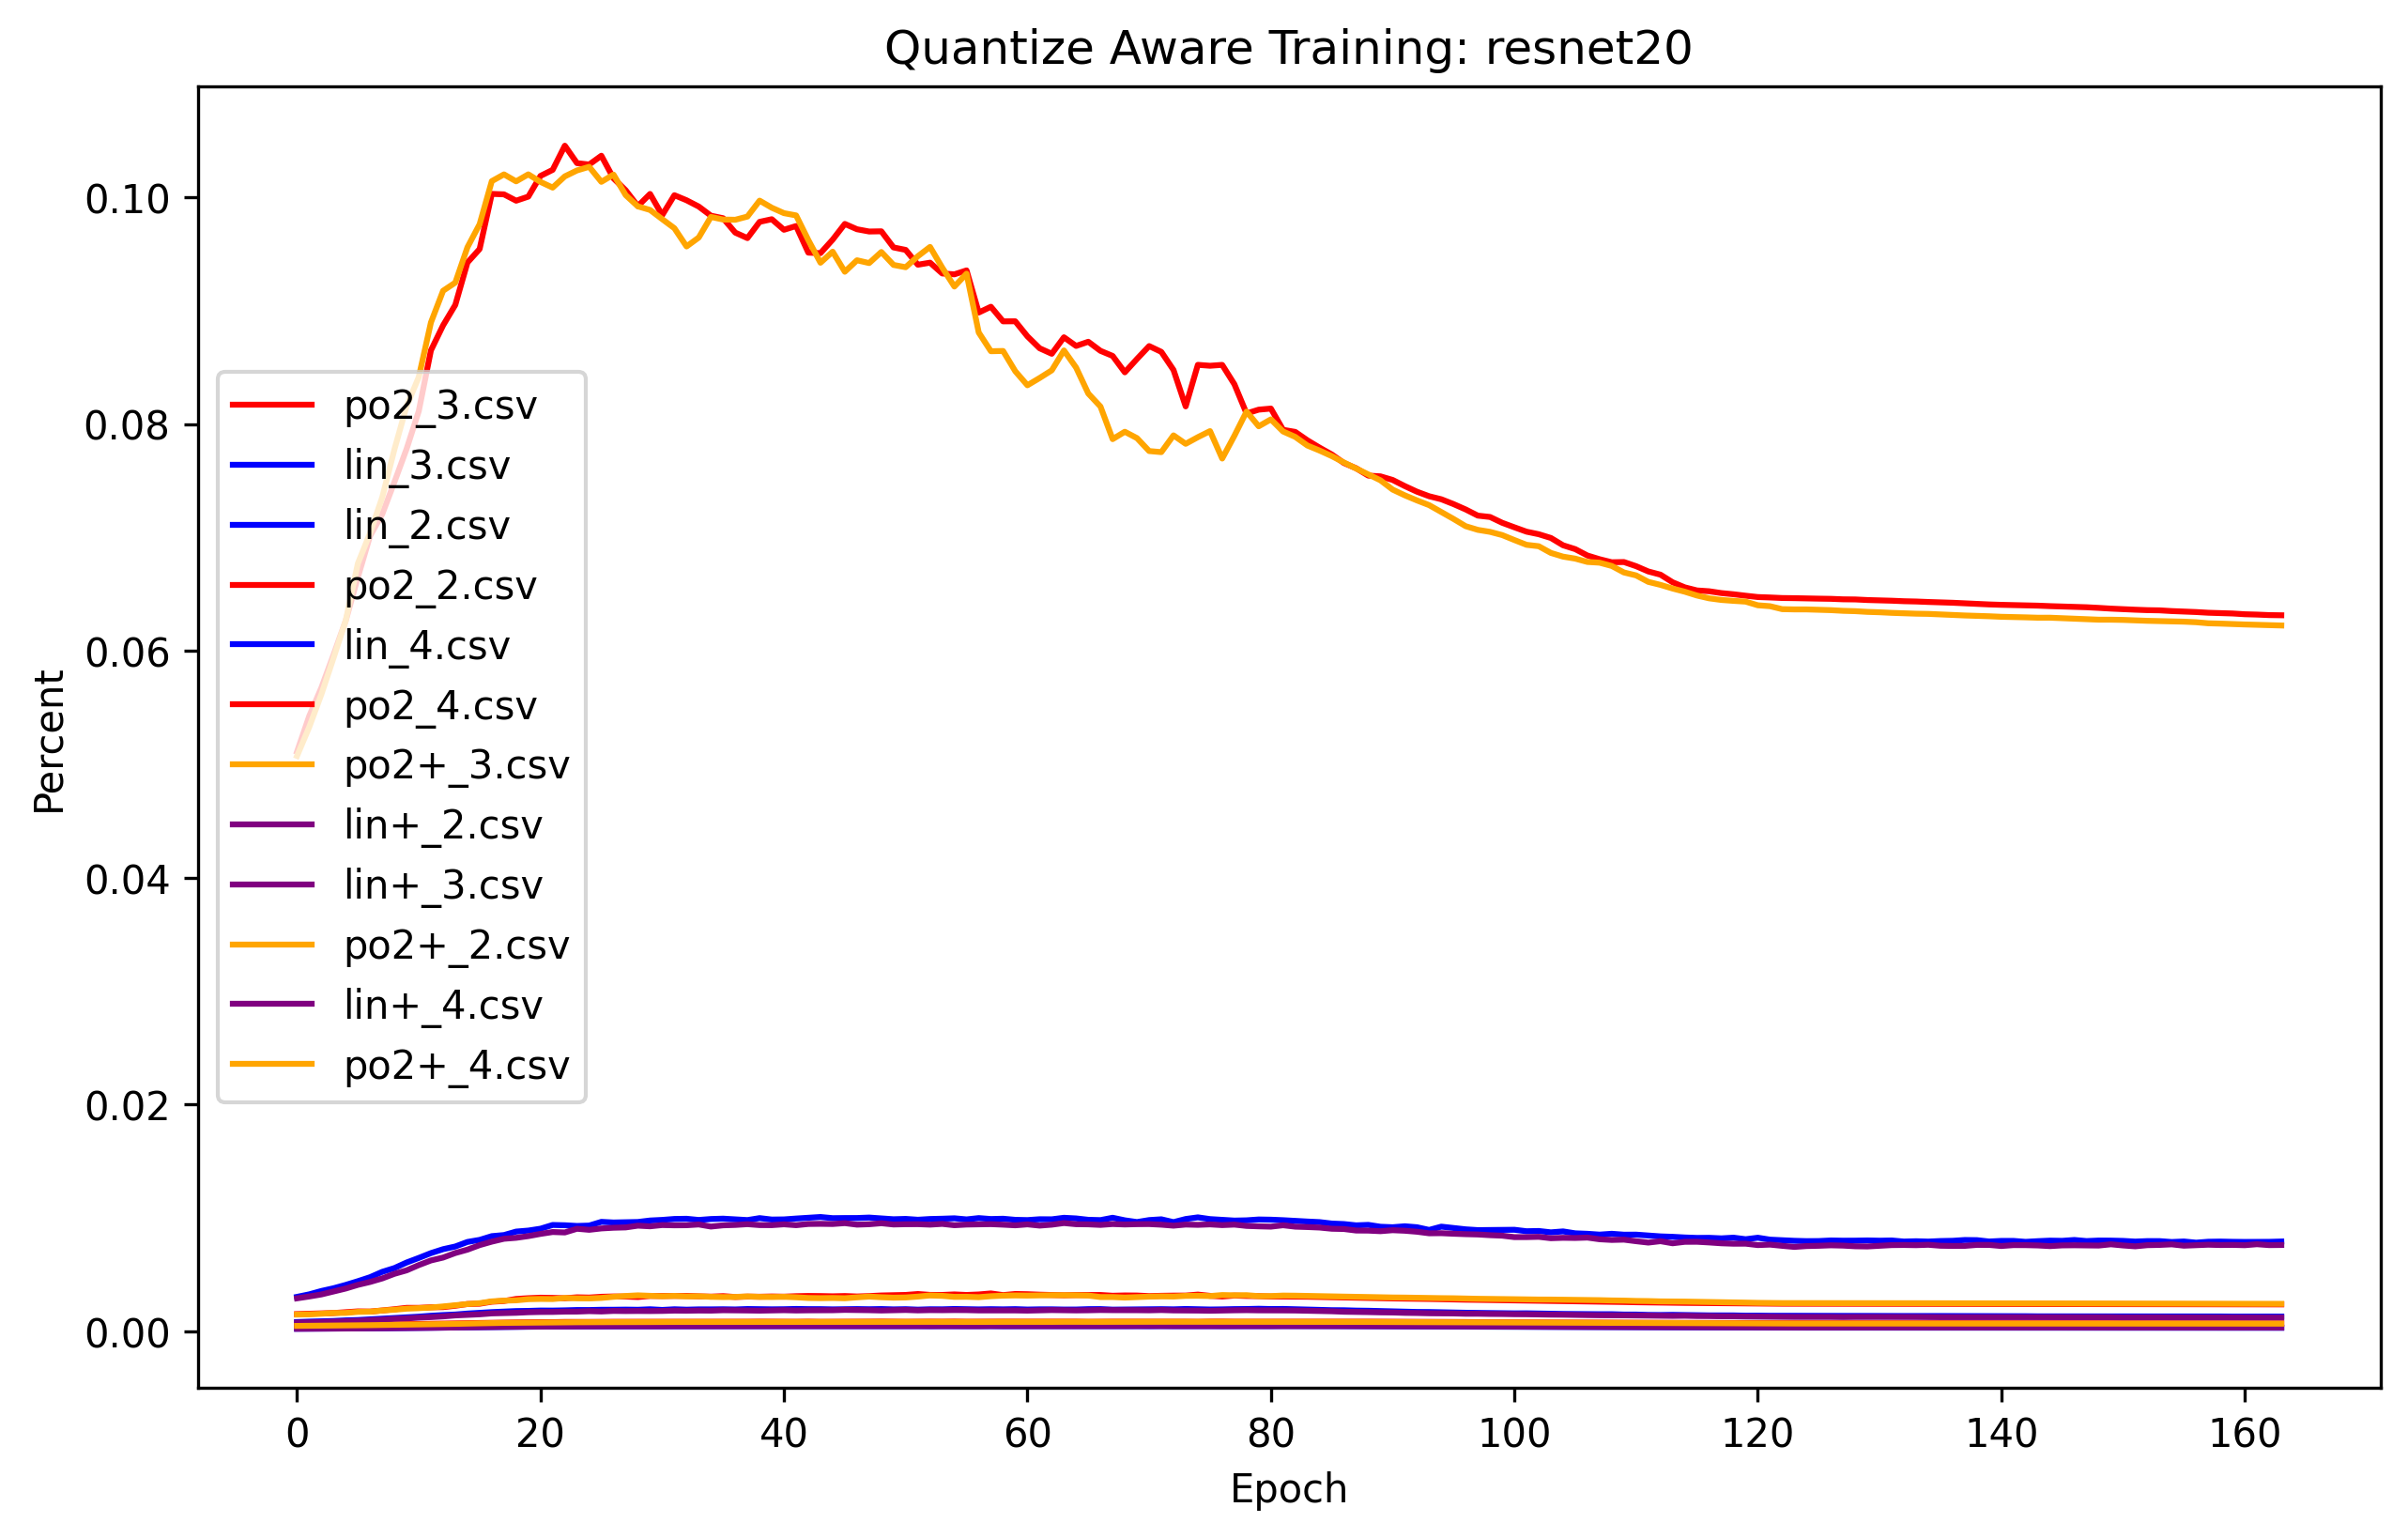

In [56]:
plot_qat_training("quantization_error", "Percent", "resnet20")

### Calculate Differences in Quantization Errors during QAT


In [88]:
from collections import defaultdict

quantization_error = defaultdict(dict)

for csv_file in [
    csv_file
    for csv_file in all_csv_files
    if "precision" not in csv_file and "_results" not in csv_file
]:
    df = pd.read_csv(csv_file)

    model_name, _, quantizer, bits = csv_file.split("/")[-1].split(".")[0].split("_")
    quantization_method = quantizer + "_" + bits

    quantization_error[model_name][quantization_method] = {
        "error": df["quantization_error"].mean(),
    }

pairs = [
    ("lin_2", "lin+_2"),
    ("lin_3", "lin+_3"),
    ("lin_4", "lin+_4"),
    ("po2_2", "po2+_2"),
    ("po2_3", "po2+_3"),
    ("po2_4", "po2+_4"),
]

results = []

for before, after in pairs:
    row = [f"{after}"]
    for model_name in quantization_error.keys():
        data = quantization_error[model_name]
        if before in data and after in data:
            error_before = data[before]["error"]
            error_after = data[after]["error"]
            percent_improvement = 100 * (error_after - error_before) / error_before
            row.append(f"{percent_improvement:.2f}%")
        else:
            row.append("-")
    results.append(row)

columns = ["Quantization"] + list(quantization_error.keys())
pd.DataFrame(results, columns=columns)

Quantization mobilevit resnet44              mobilenet resnet56 resnet20  \
0       lin+_2   -94.19%   -4.92%  88966734699263552.00%   -3.96%   -5.21%   
1       lin+_3    -5.16%   -2.98%                 -6.15%   -3.74%   -5.75%   
2       lin+_4     9.32%    2.44%                  9.04%    2.26%    2.49%   
3       po2+_2    -1.73%   -6.85%                  2.96%   -0.10%   -1.37%   
4       po2+_3    -0.22%    7.14%                  1.32%    4.70%    0.35%   
5       po2+_4    -9.25%   -3.41%                 -5.35%   -2.99%   -3.03%   

  resnet32  
0   -3.61%  
1   -3.94%  
2    2.69%  
3    0.90%  
4    5.89%  
5   -3.08%

In [174]:
def get_results(model_name: str, y_min: float, y_max: float, qat: bool):
    result_file = f"results/{model_name}_cifar_results.csv"
    df = pd.read_csv(result_file)
    full_precision_acc = df.loc[df["model"] == "full_precision", "test_acc"].values[0]
    df[["type", "quantizer", "bits"]] = df["model"].str.split("_", expand=True)
    df_pivot = df.pivot_table(
        index=["type", "bits"], columns="quantizer", values="test_acc"
    )
    df_pivot["lin+ improvement (%)"] = round(
        100 * (df_pivot["lin+"] - df_pivot["lin"]) / df_pivot["lin"], 2
    )
    df_pivot["po2+ improvement (%)"] = round(
        100 * (df_pivot["po2+"] - df_pivot["po2"]) / df_pivot["po2"], 2
    )
    column_order = [
        "lin",
        "lin+",
        "lin+ improvement (%)",
        "po2",
        "po2+",
        "po2+ improvement (%)",
    ]
    df_pivot = df_pivot.reindex(columns=column_order)

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    linestyles = {"": "-", "+": "--"}
    qtype = "qat" if qat else "ptq"
    for quantizer in ["lin", "lin+", "po2", "po2+"]:
        accuracies = df_pivot.loc[qtype][quantizer].values
        bits = df_pivot.loc[qtype].index.astype(int)
        linestyle = linestyles["+" if "+" in quantizer else ""]
        ax.plot(bits, accuracies, marker="o", linestyle=linestyle, label=quantizer)

    ax.axhline(
        full_precision_acc,
        color="black",
        linestyle="--",
        label="Full Precision",
    )

    ax.set_xlabel("Number of Bits")
    ax.set_ylabel("Accuracy")
    ax.set_title(
        f"Test Accuracy: {model_name} QAT"
        if qat
        else f"Test Accuracy: {model_name} PTQ"
    )
    ax.set_xticks([2, 3, 4])
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return df_pivot

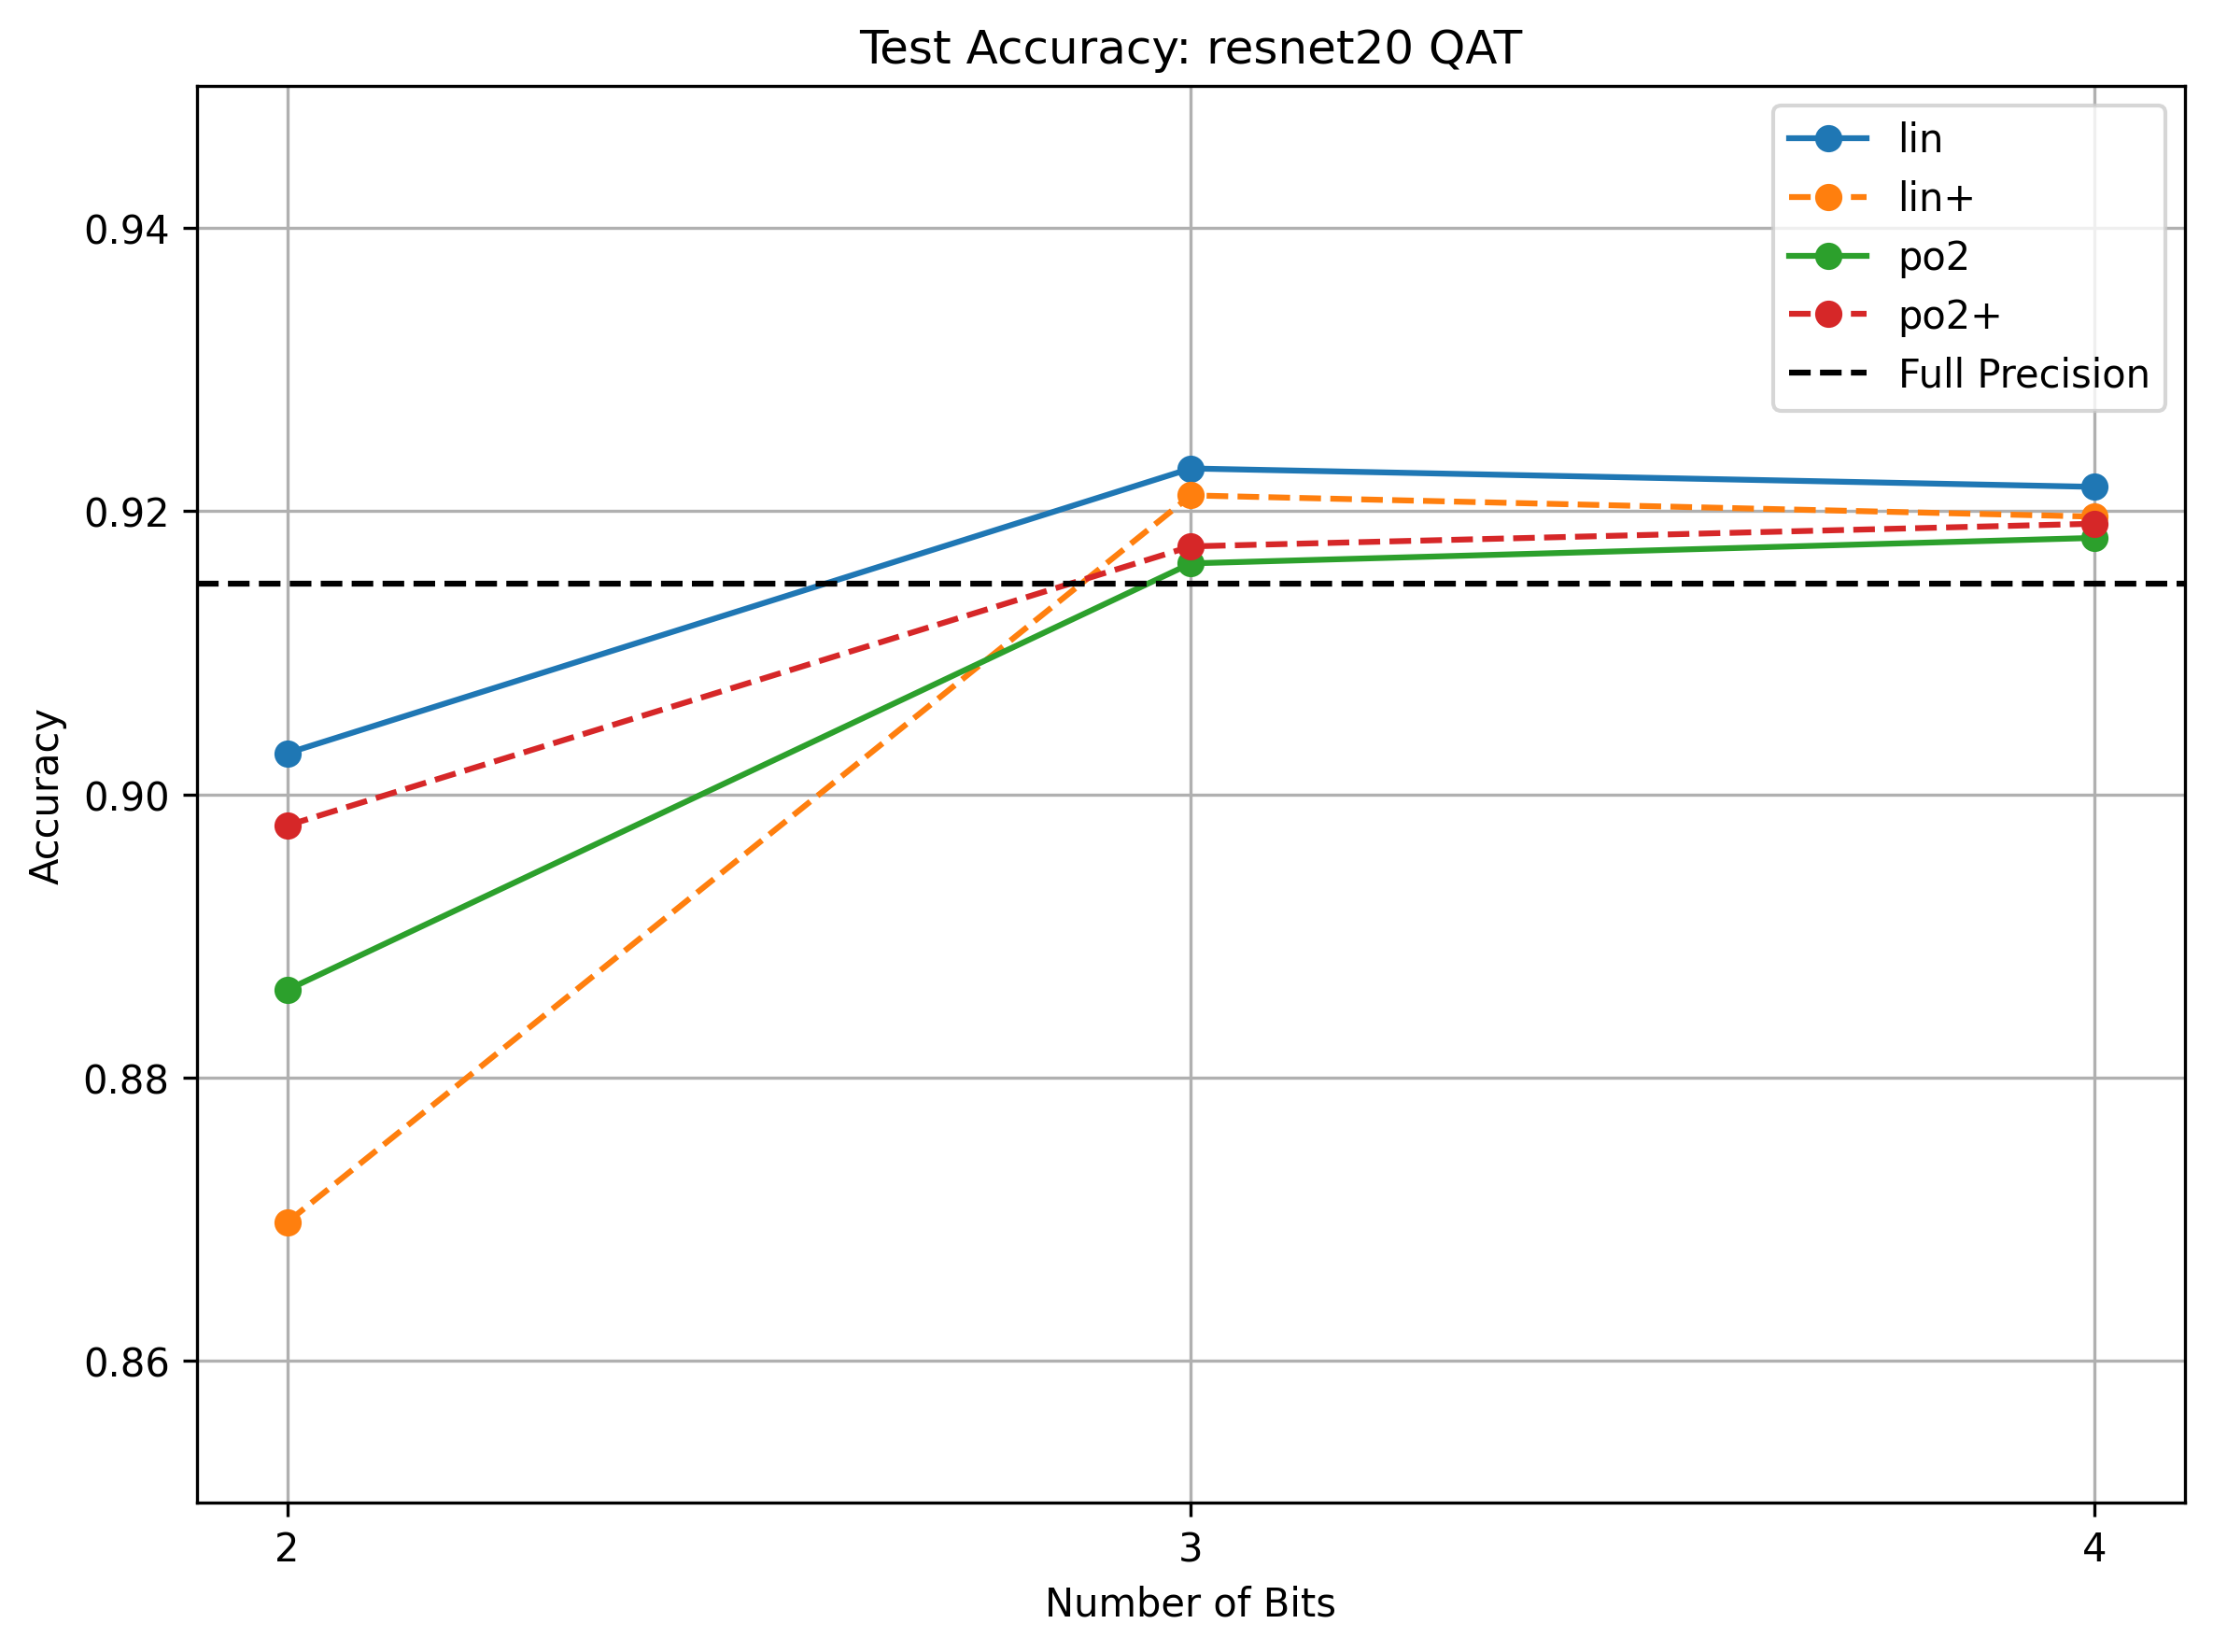

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.1062  0.1027                 -3.30  0.0952  0.0957   
     3     0.7836  0.7362                 -6.05  0.7531  0.7742   
     4     0.8952  0.8826                 -1.41  0.8636  0.8750   
qat  2     0.9029  0.8698                 -3.67  0.8862  0.8978   
     3     0.9230  0.9211                 -0.21  0.9163  0.9175   
     4     0.9217  0.9196                 -0.23  0.9181  0.9191   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                     0.53  
     3                     2.80  
     4                     1.32  
qat  2                     1.31  
     3                     0.13  
     4                     0.11

In [175]:
get_results("resnet20", 0.85, 0.95, qat=True)

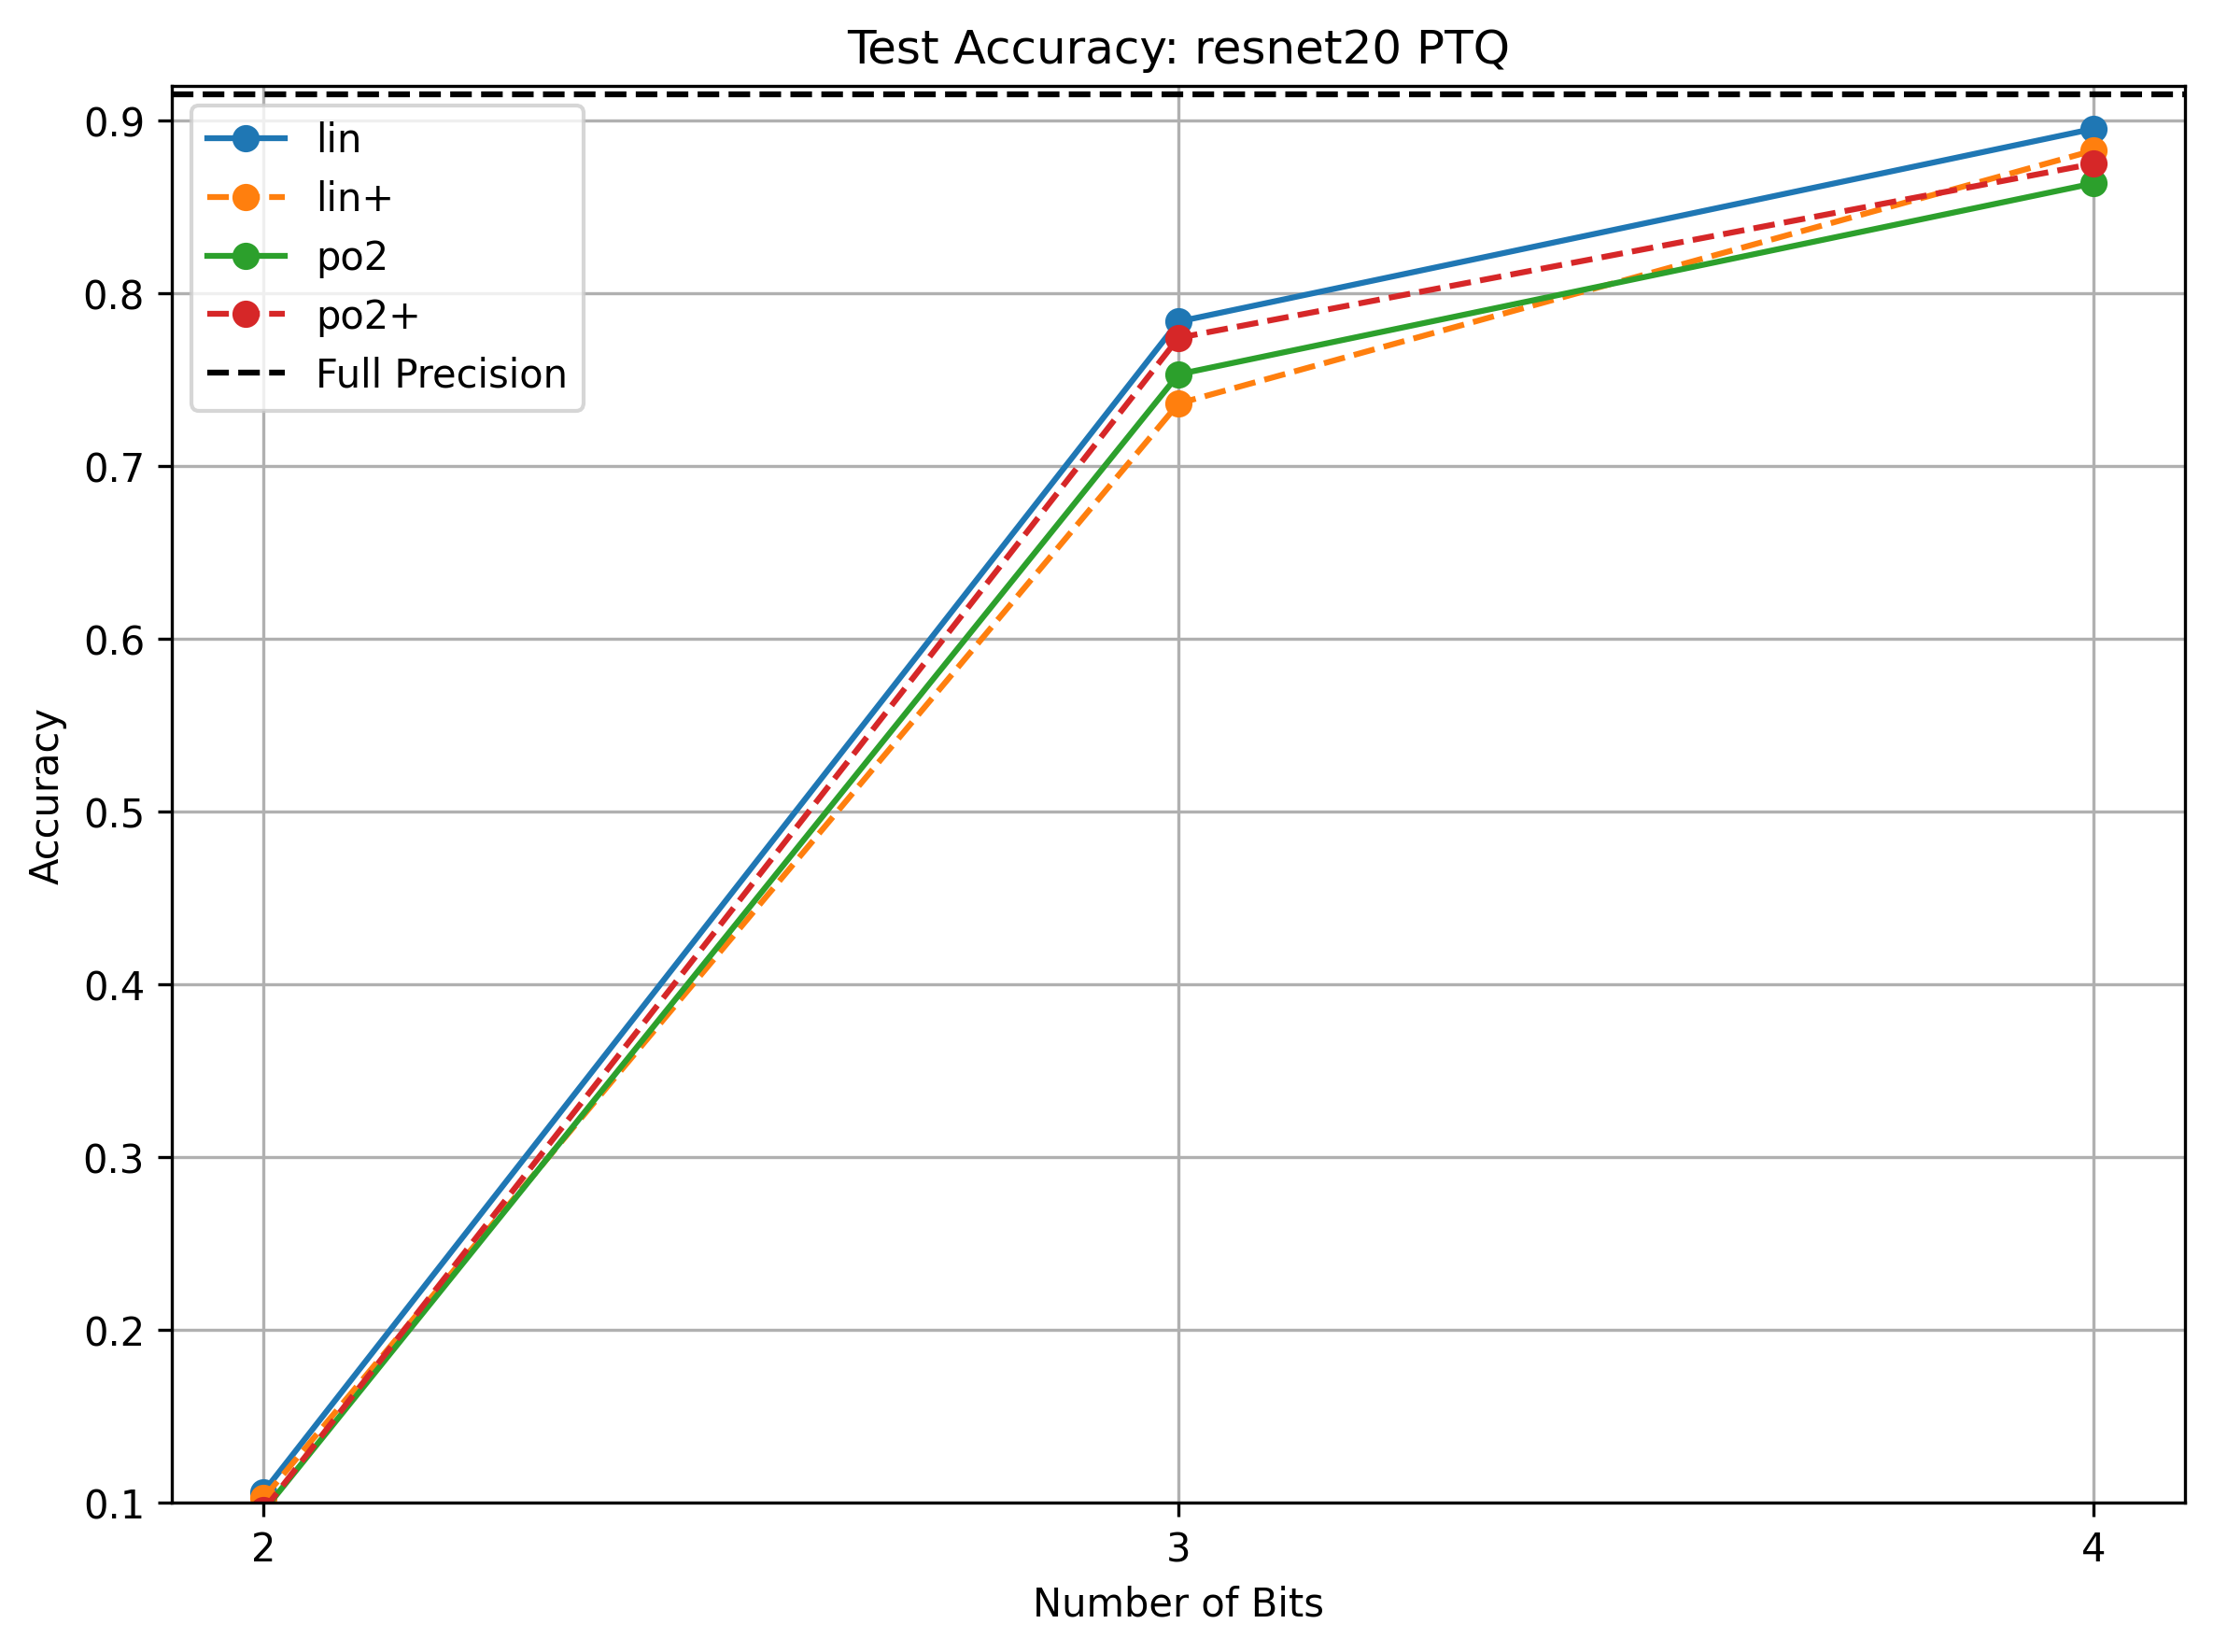

In [178]:
_ = get_results("resnet20", 0.1, 0.92, qat=False)

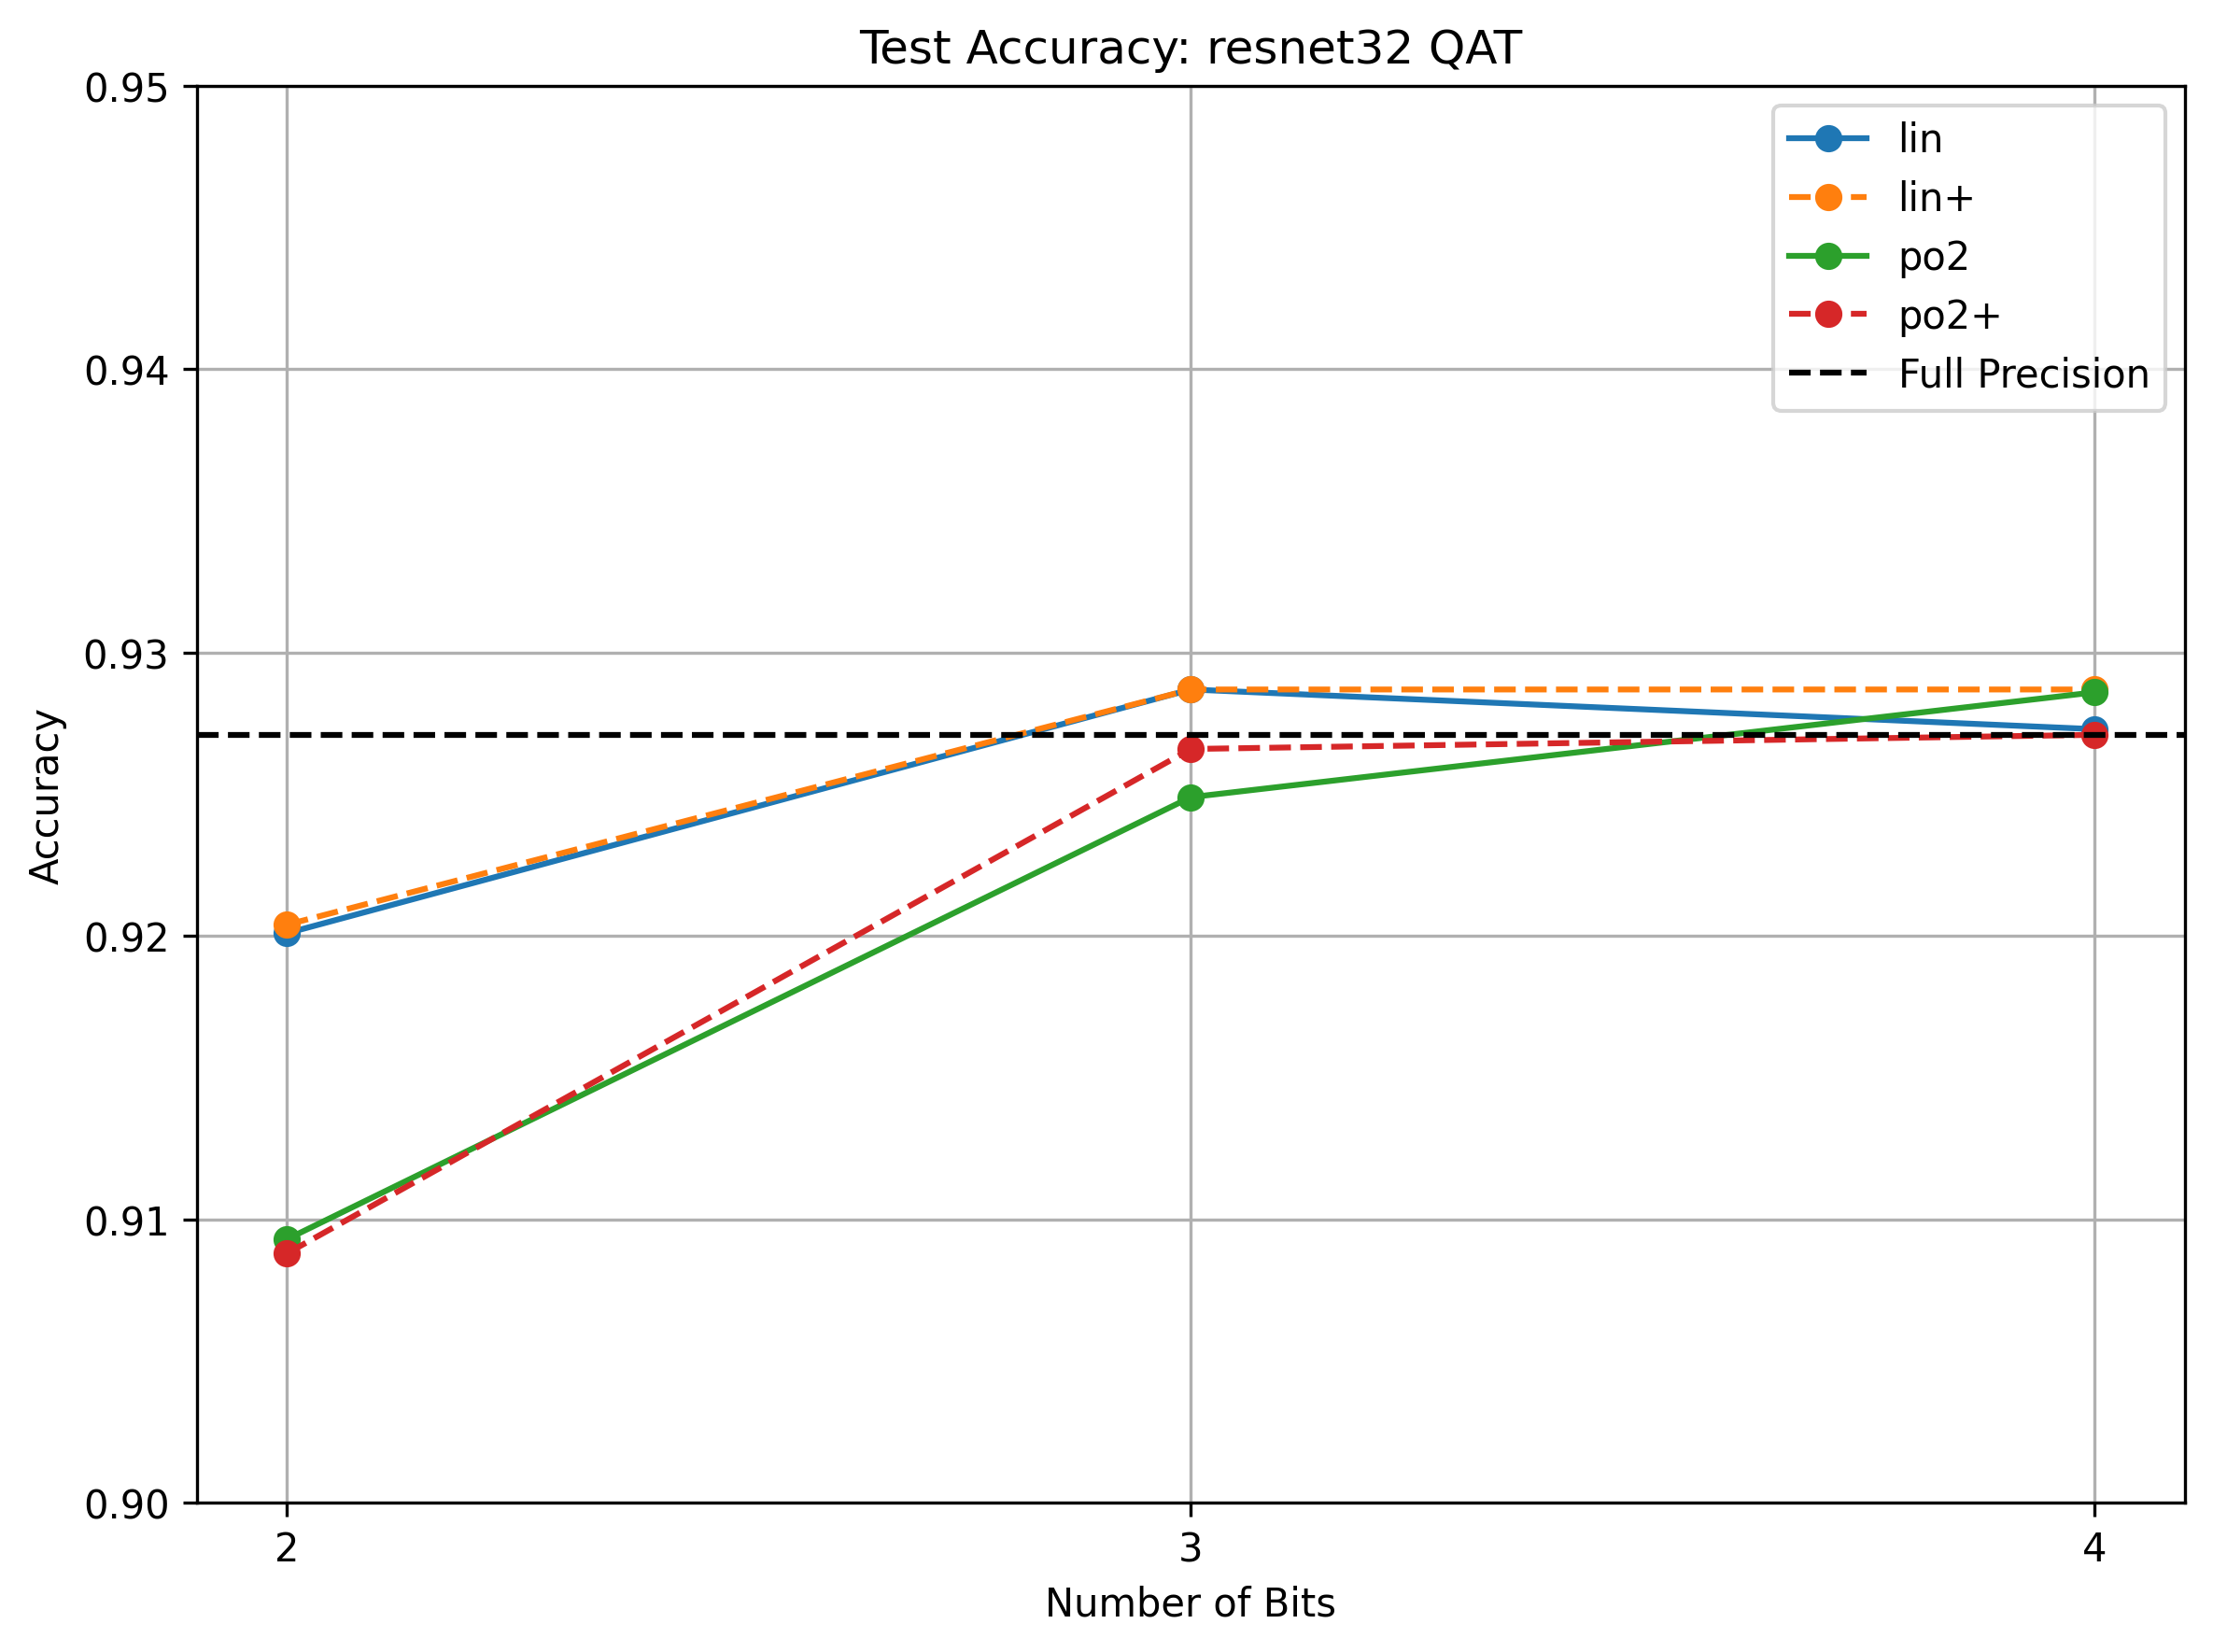

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.2173  0.1637                -24.67  0.1020  0.1017   
     3     0.8584  0.8356                 -2.66  0.7657  0.8013   
     4     0.9094  0.9067                 -0.30  0.8934  0.8815   
qat  2     0.9201  0.9204                  0.03  0.9093  0.9088   
     3     0.9287  0.9287                  0.00  0.9249  0.9266   
     4     0.9273  0.9287                  0.15  0.9286  0.9271   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                    -0.29  
     3                     4.65  
     4                    -1.33  
qat  2                    -0.05  
     3                     0.18  
     4                    -0.16

In [182]:
get_results("resnet32", 0.9, 0.95, qat=True)

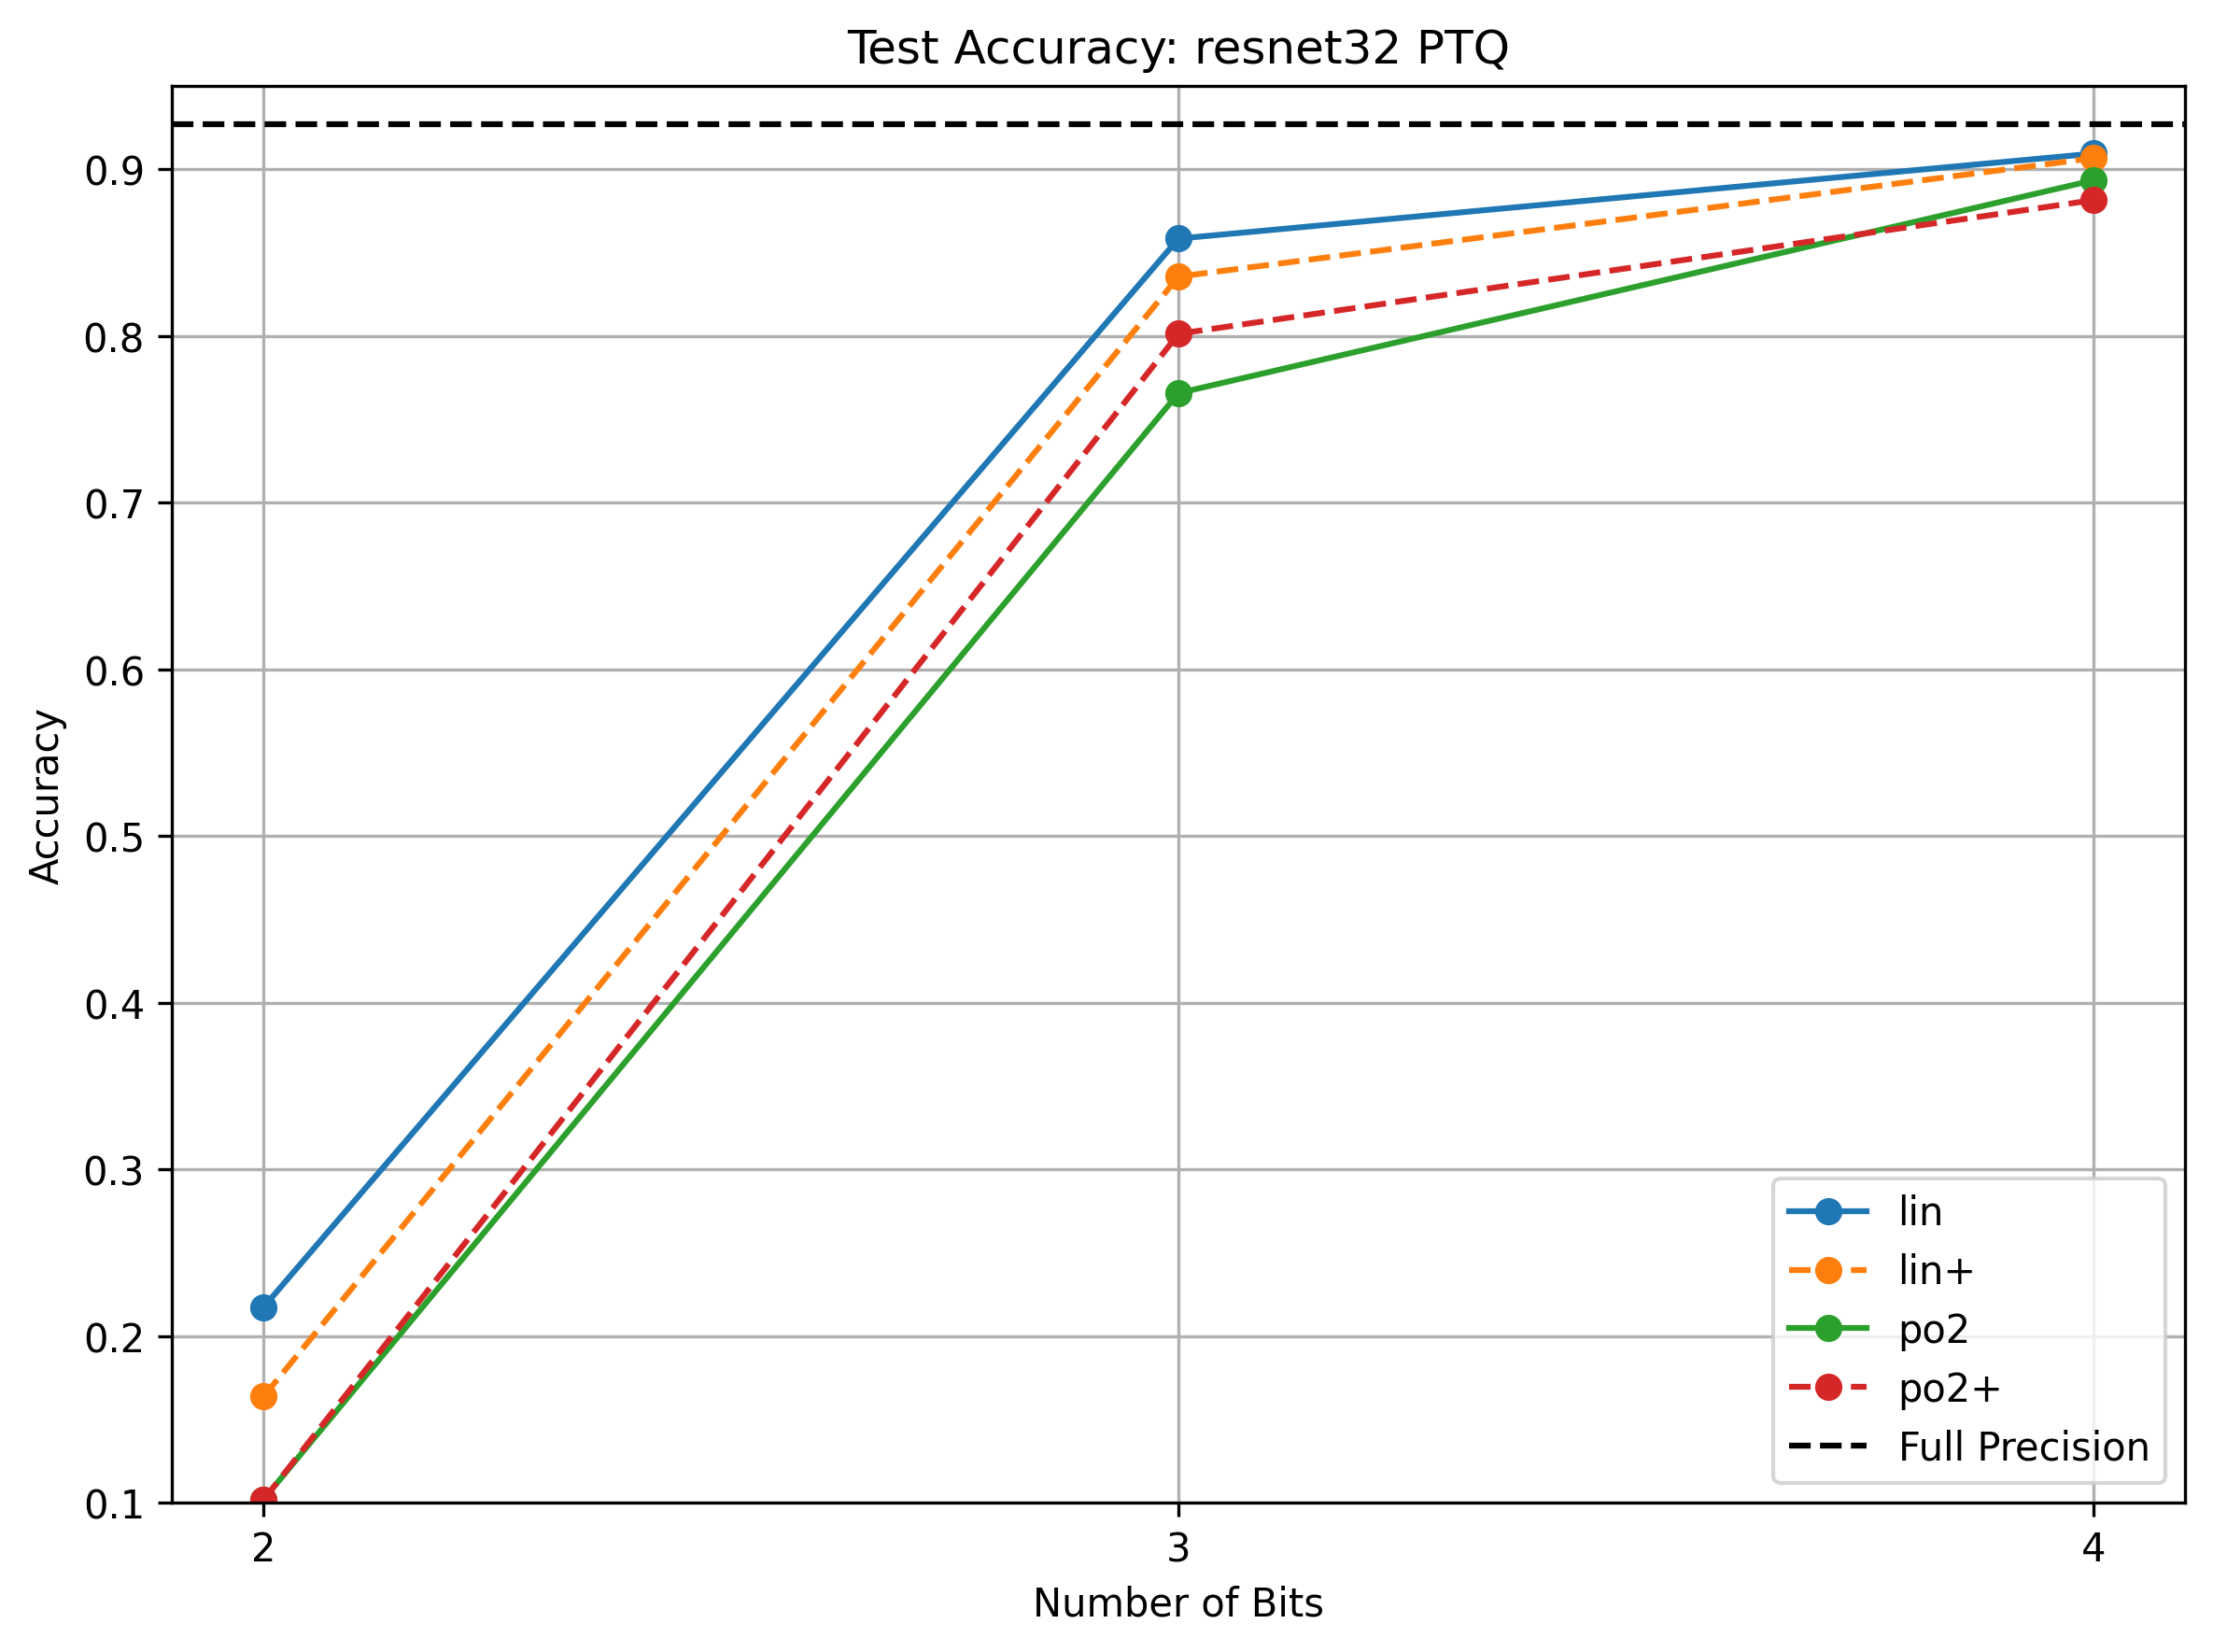

In [184]:
_ = get_results("resnet32", 0.1, 0.95, qat=False)

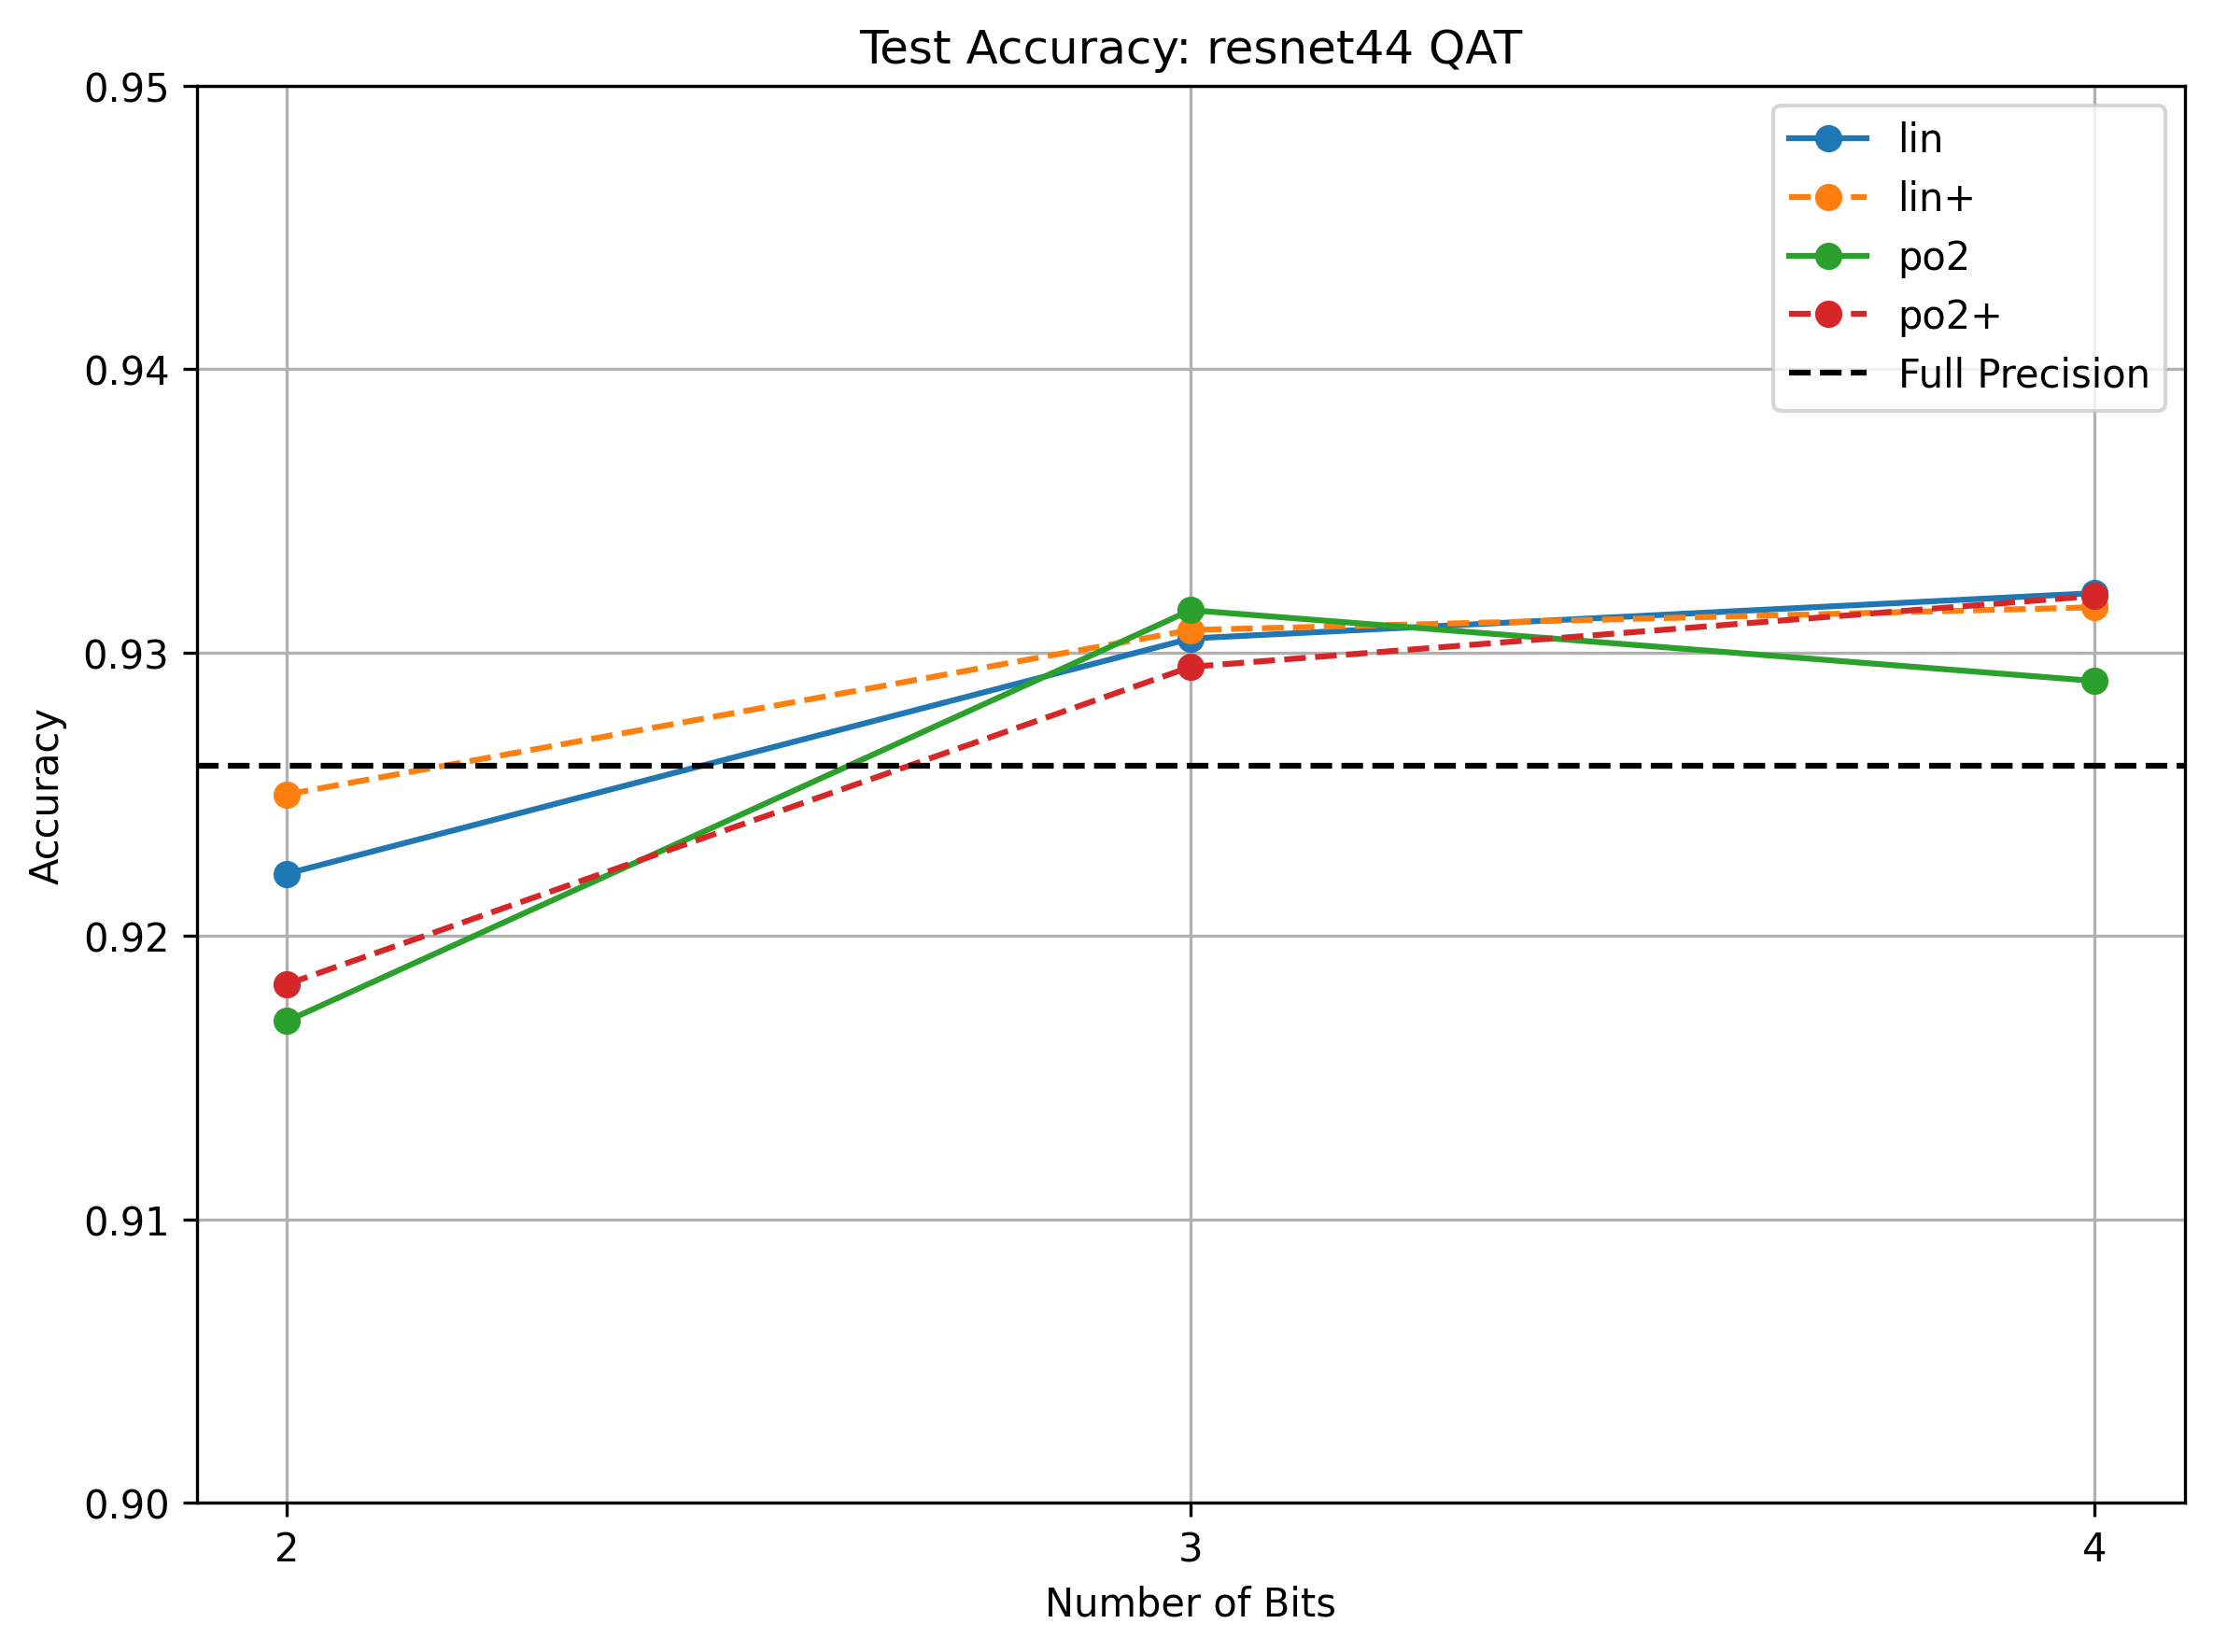

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.2667  0.2255                -15.45  0.1000  0.1000   
     3     0.8037  0.7296                 -9.22  0.8365  0.8802   
     4     0.9117  0.9064                 -0.58  0.8866  0.9085   
qat  2     0.9222  0.9250                  0.30  0.9170  0.9183   
     3     0.9305  0.9308                  0.03  0.9315  0.9295   
     4     0.9321  0.9316                 -0.05  0.9290  0.9320   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                     0.00  
     3                     5.22  
     4                     2.47  
qat  2                     0.14  
     3                    -0.21  
     4                     0.32

In [185]:
get_results("resnet44", 0.9, 0.95, qat=True)

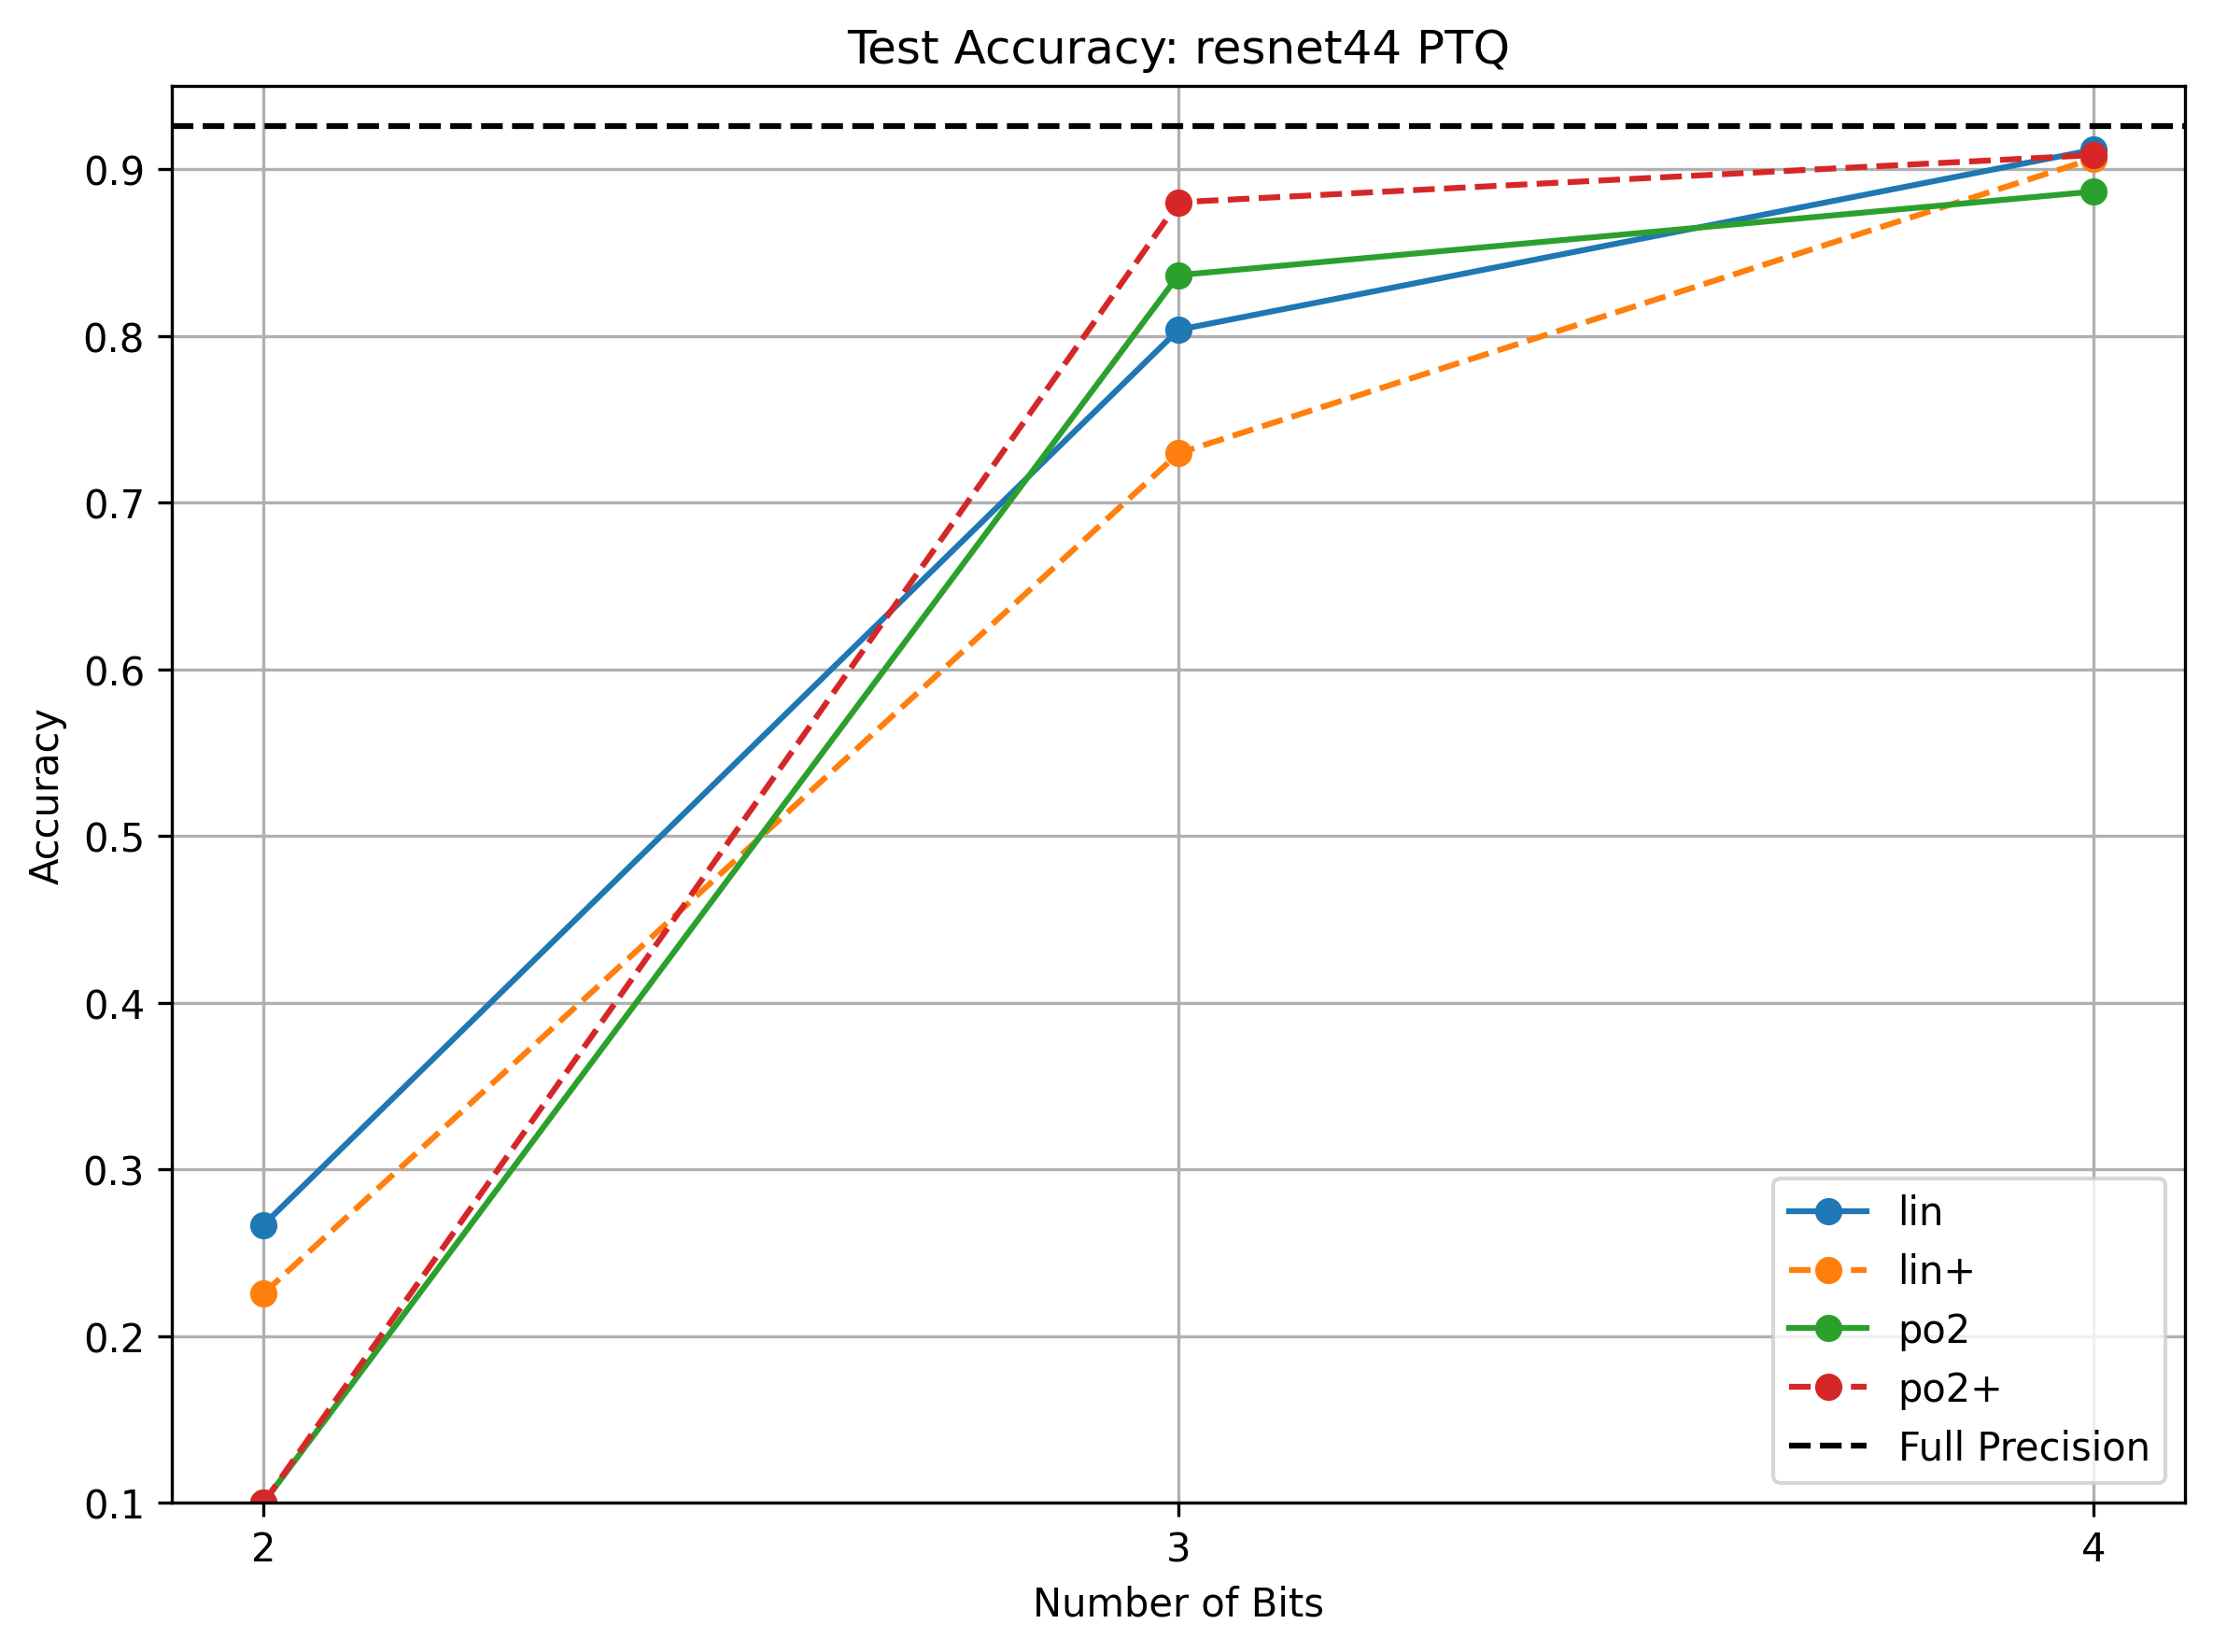

In [186]:
_ = get_results("resnet44", 0.1, 0.95, qat=False)

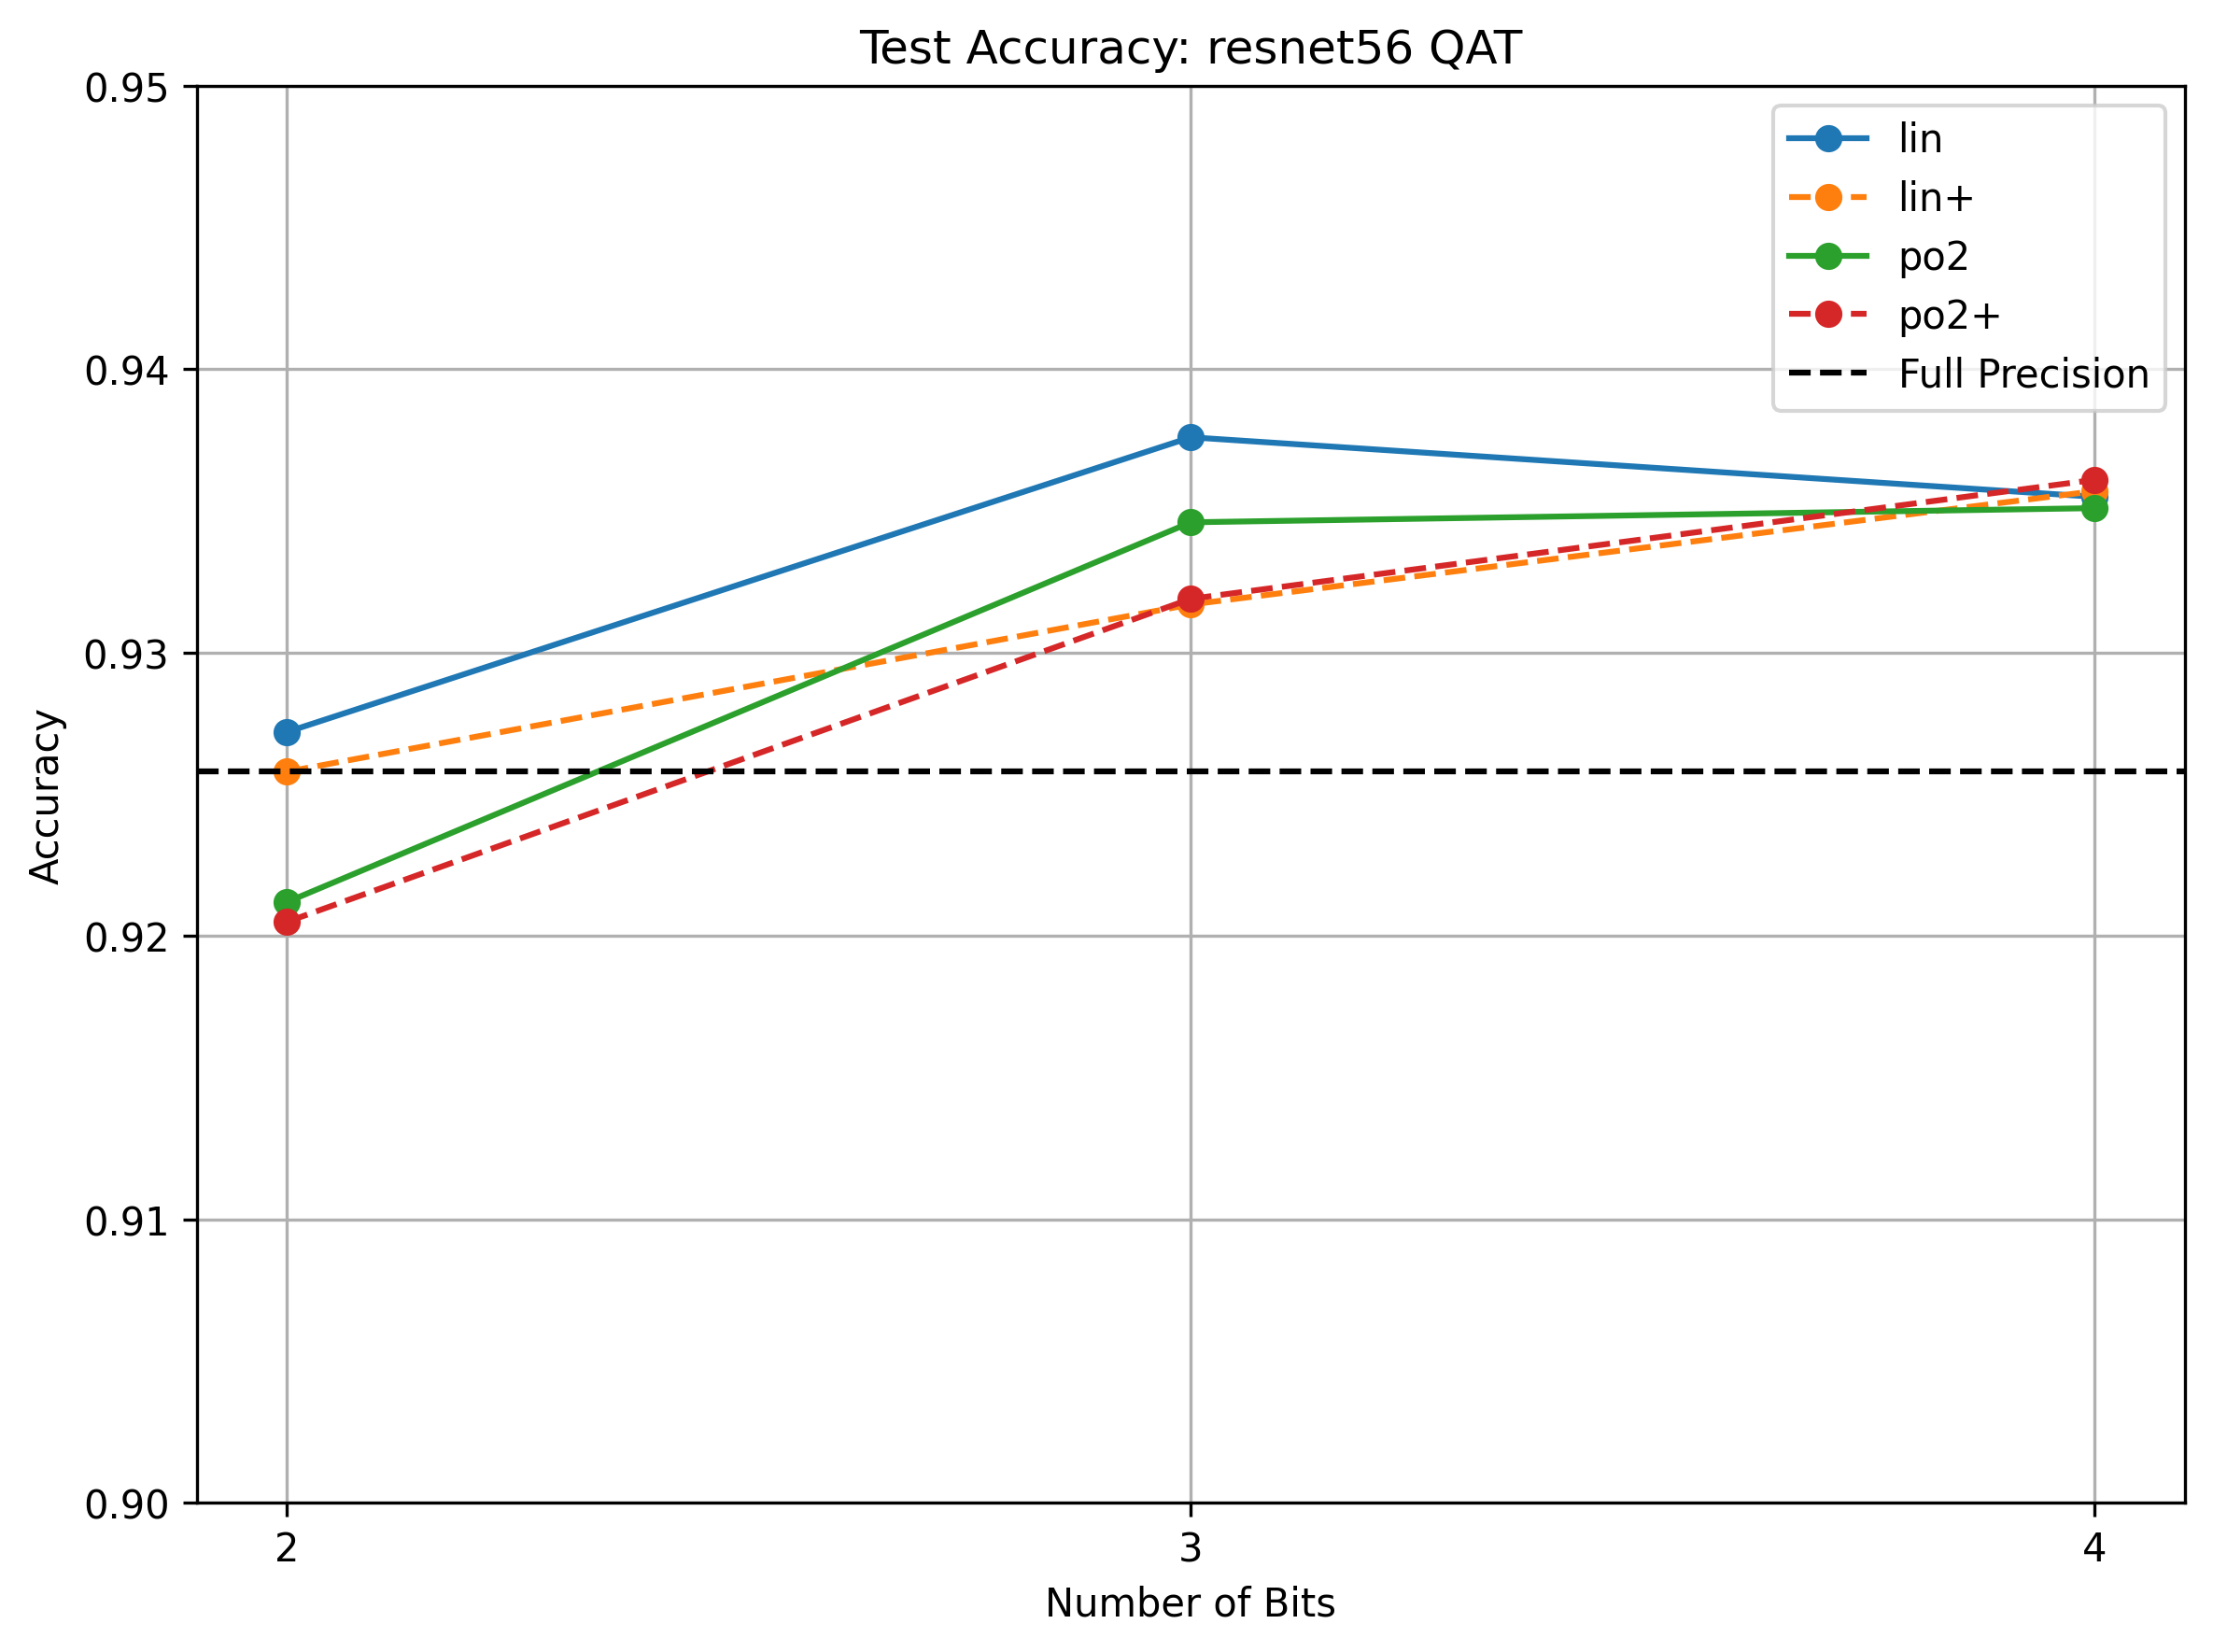

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.1965  0.1173                -40.31  0.1087  0.1096   
     3     0.8700  0.8201                 -5.74  0.8599  0.8772   
     4     0.9108  0.8984                 -1.36  0.9052  0.8957   
qat  2     0.9272  0.9258                 -0.15  0.9212  0.9205   
     3     0.9376  0.9317                 -0.63  0.9346  0.9319   
     4     0.9355  0.9357                  0.02  0.9351  0.9361   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                     0.83  
     3                     2.01  
     4                    -1.05  
qat  2                    -0.08  
     3                    -0.29  
     4                     0.11

In [187]:
get_results("resnet56", 0.9, 0.95, qat=True)

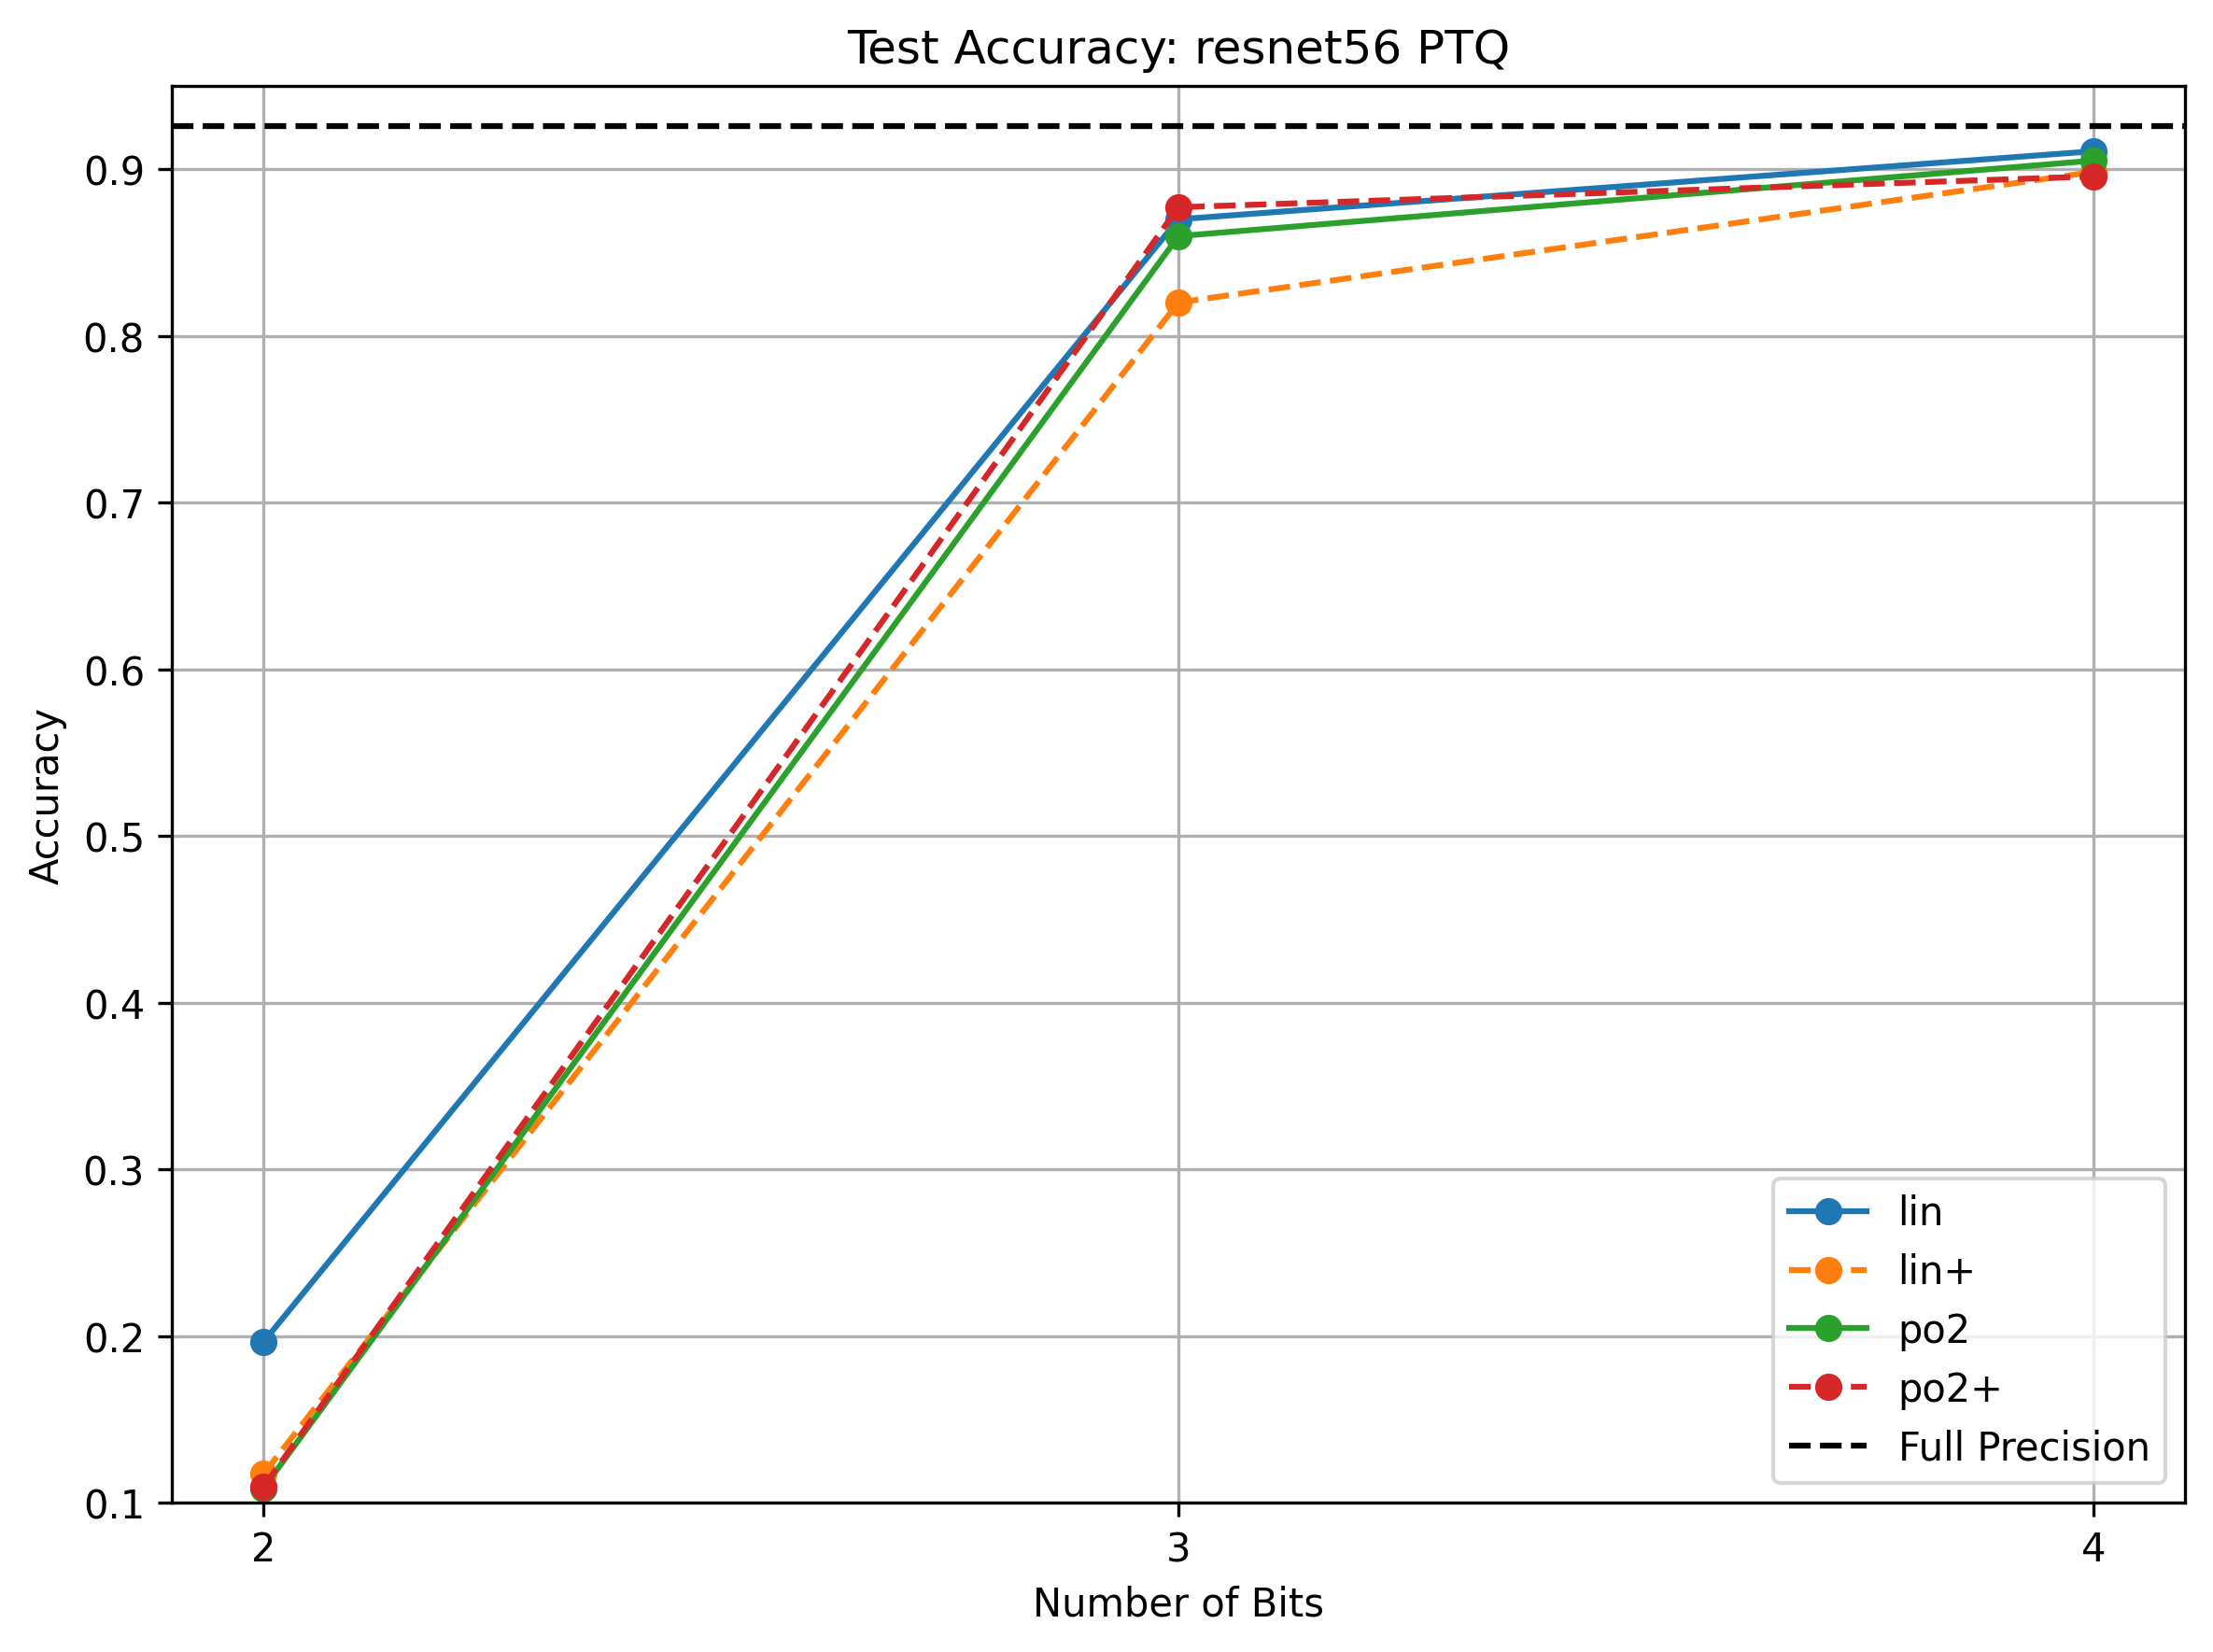

In [189]:
_ = get_results("resnet56", 0.1, 0.95, qat=False)

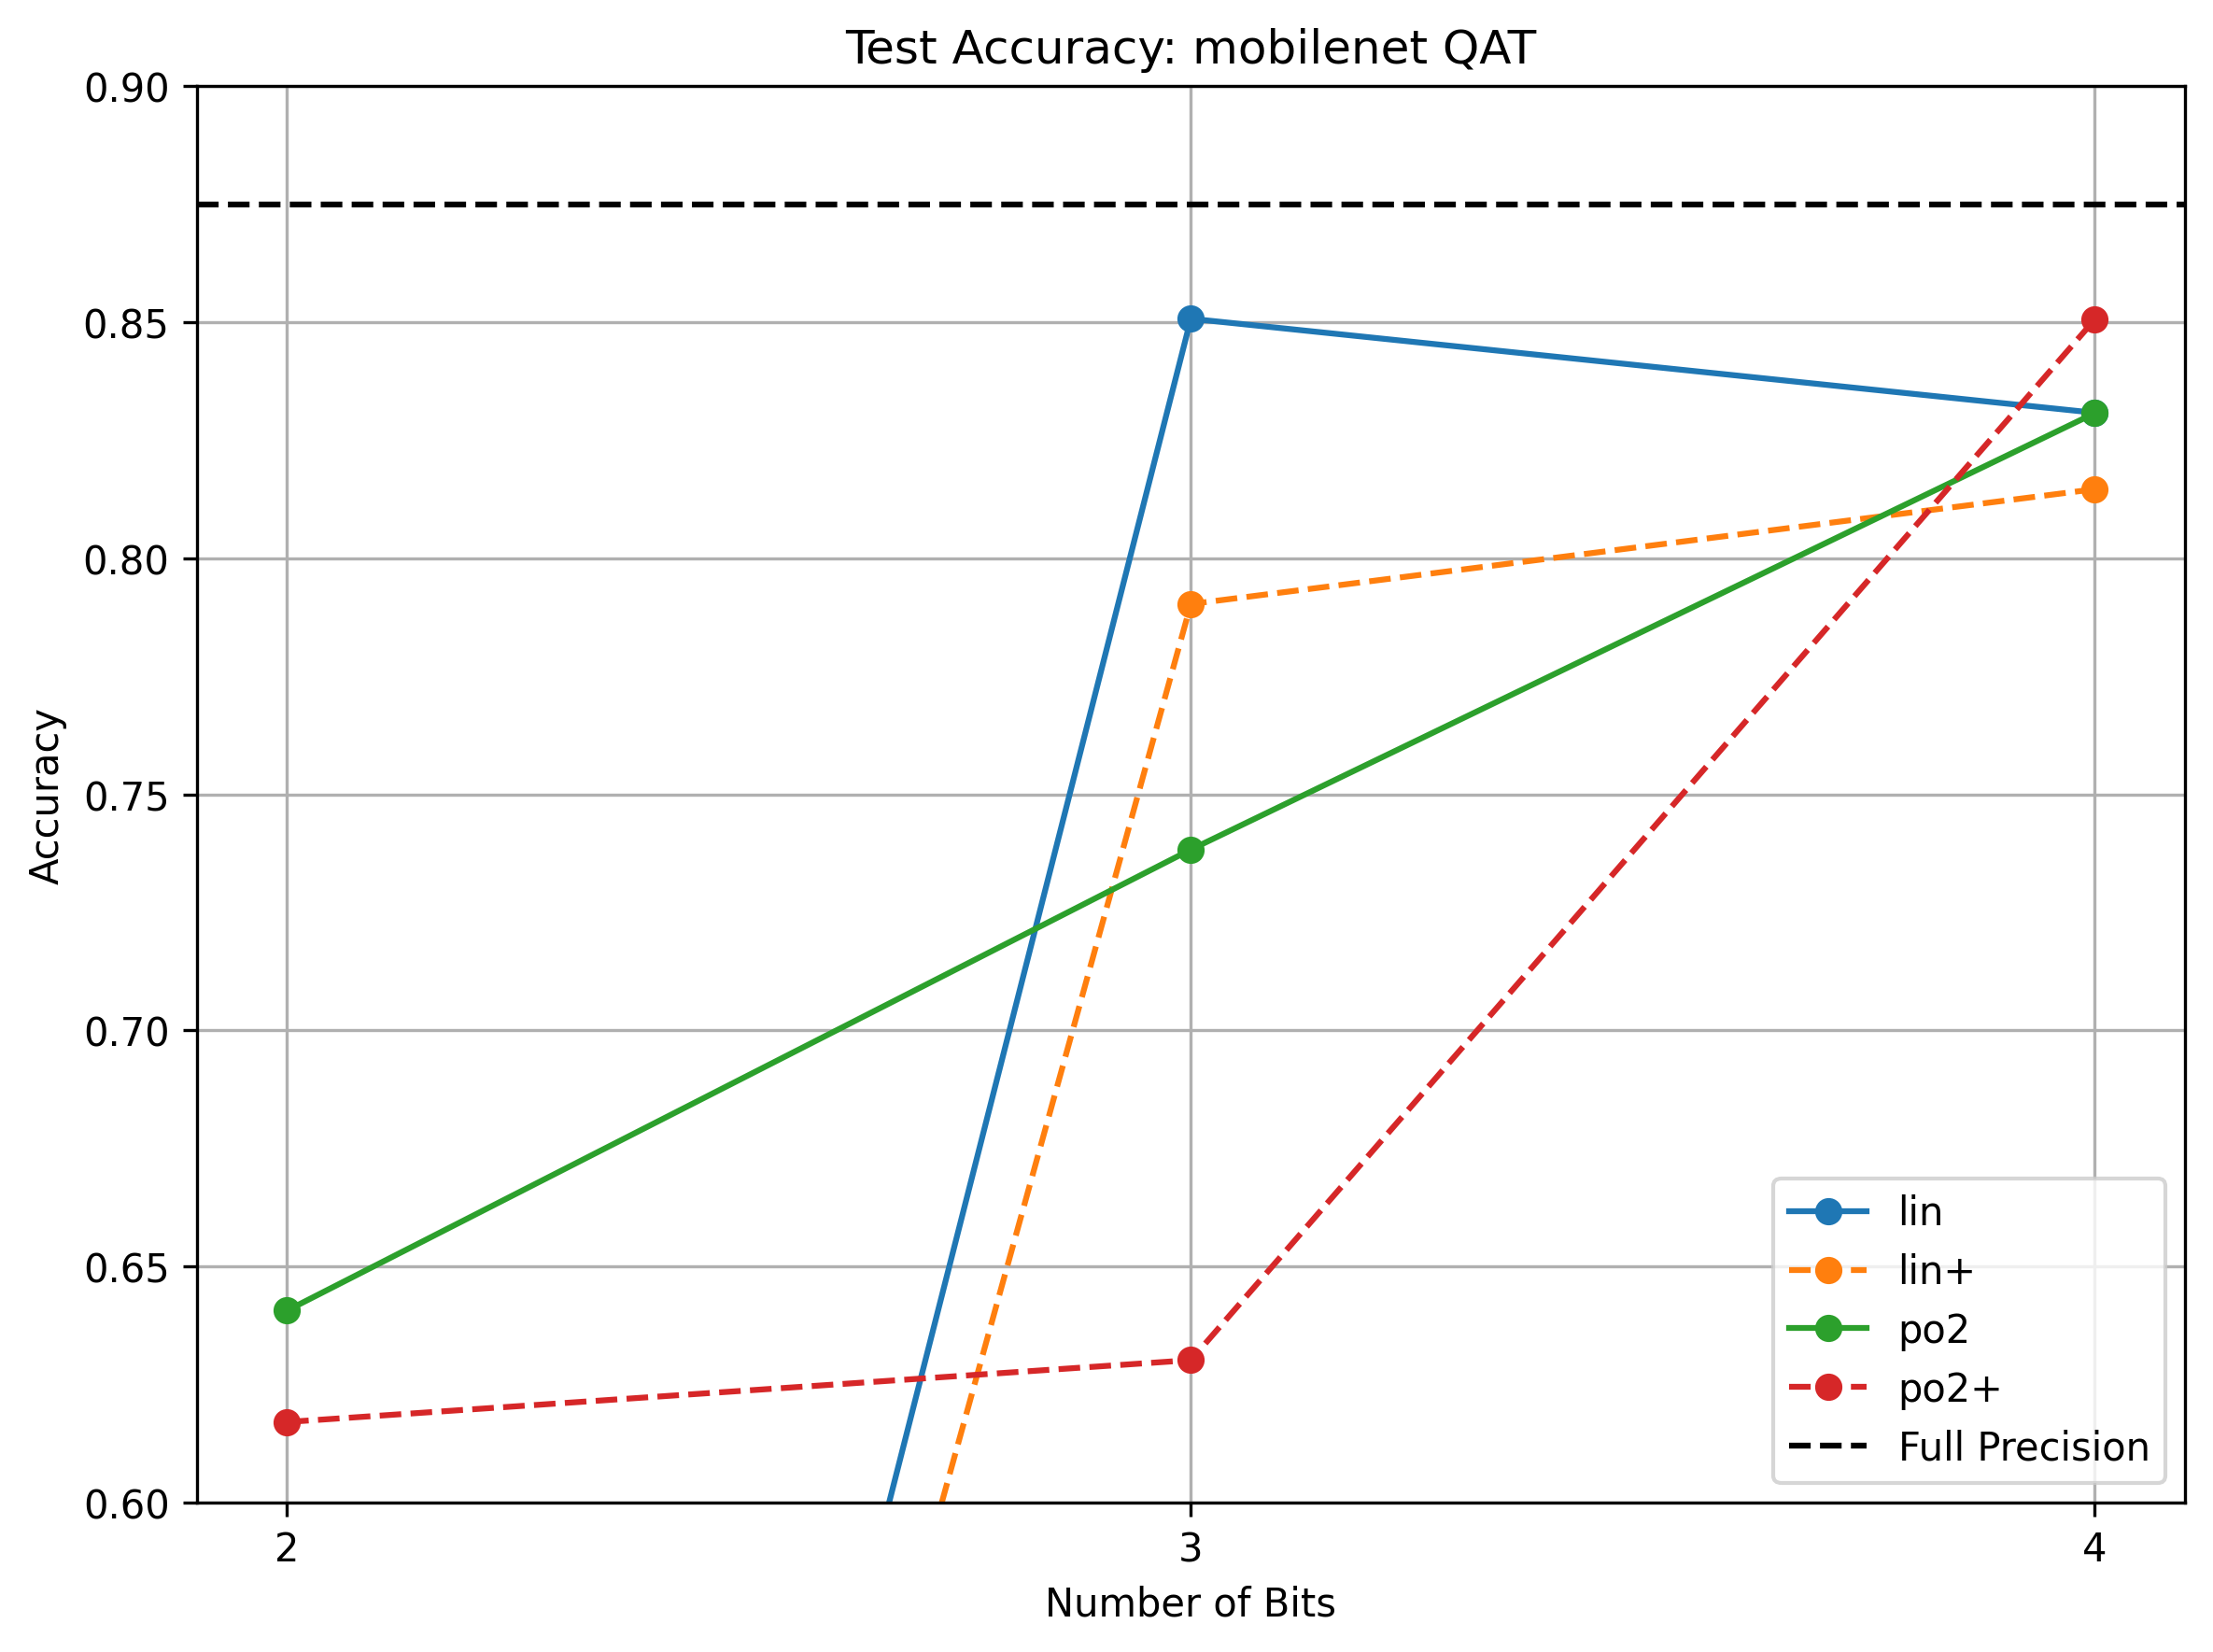

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.1608  0.1851                 15.11  0.1045  0.1007   
     3     0.5555  0.5496                 -1.06  0.6367  0.6593   
     4     0.7879  0.7861                 -0.23  0.7401  0.7341   
qat  2     0.1000  0.1000                  0.00  0.6407  0.6171   
     3     0.8507  0.7903                 -7.10  0.7383  0.6302   
     4     0.8308  0.8146                 -1.95  0.8307  0.8505   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                    -3.64  
     3                     3.55  
     4                    -0.81  
qat  2                    -3.68  
     3                   -14.64  
     4                     2.38

In [194]:
get_results("mobilenet", 0.6, 0.9, qat=True)

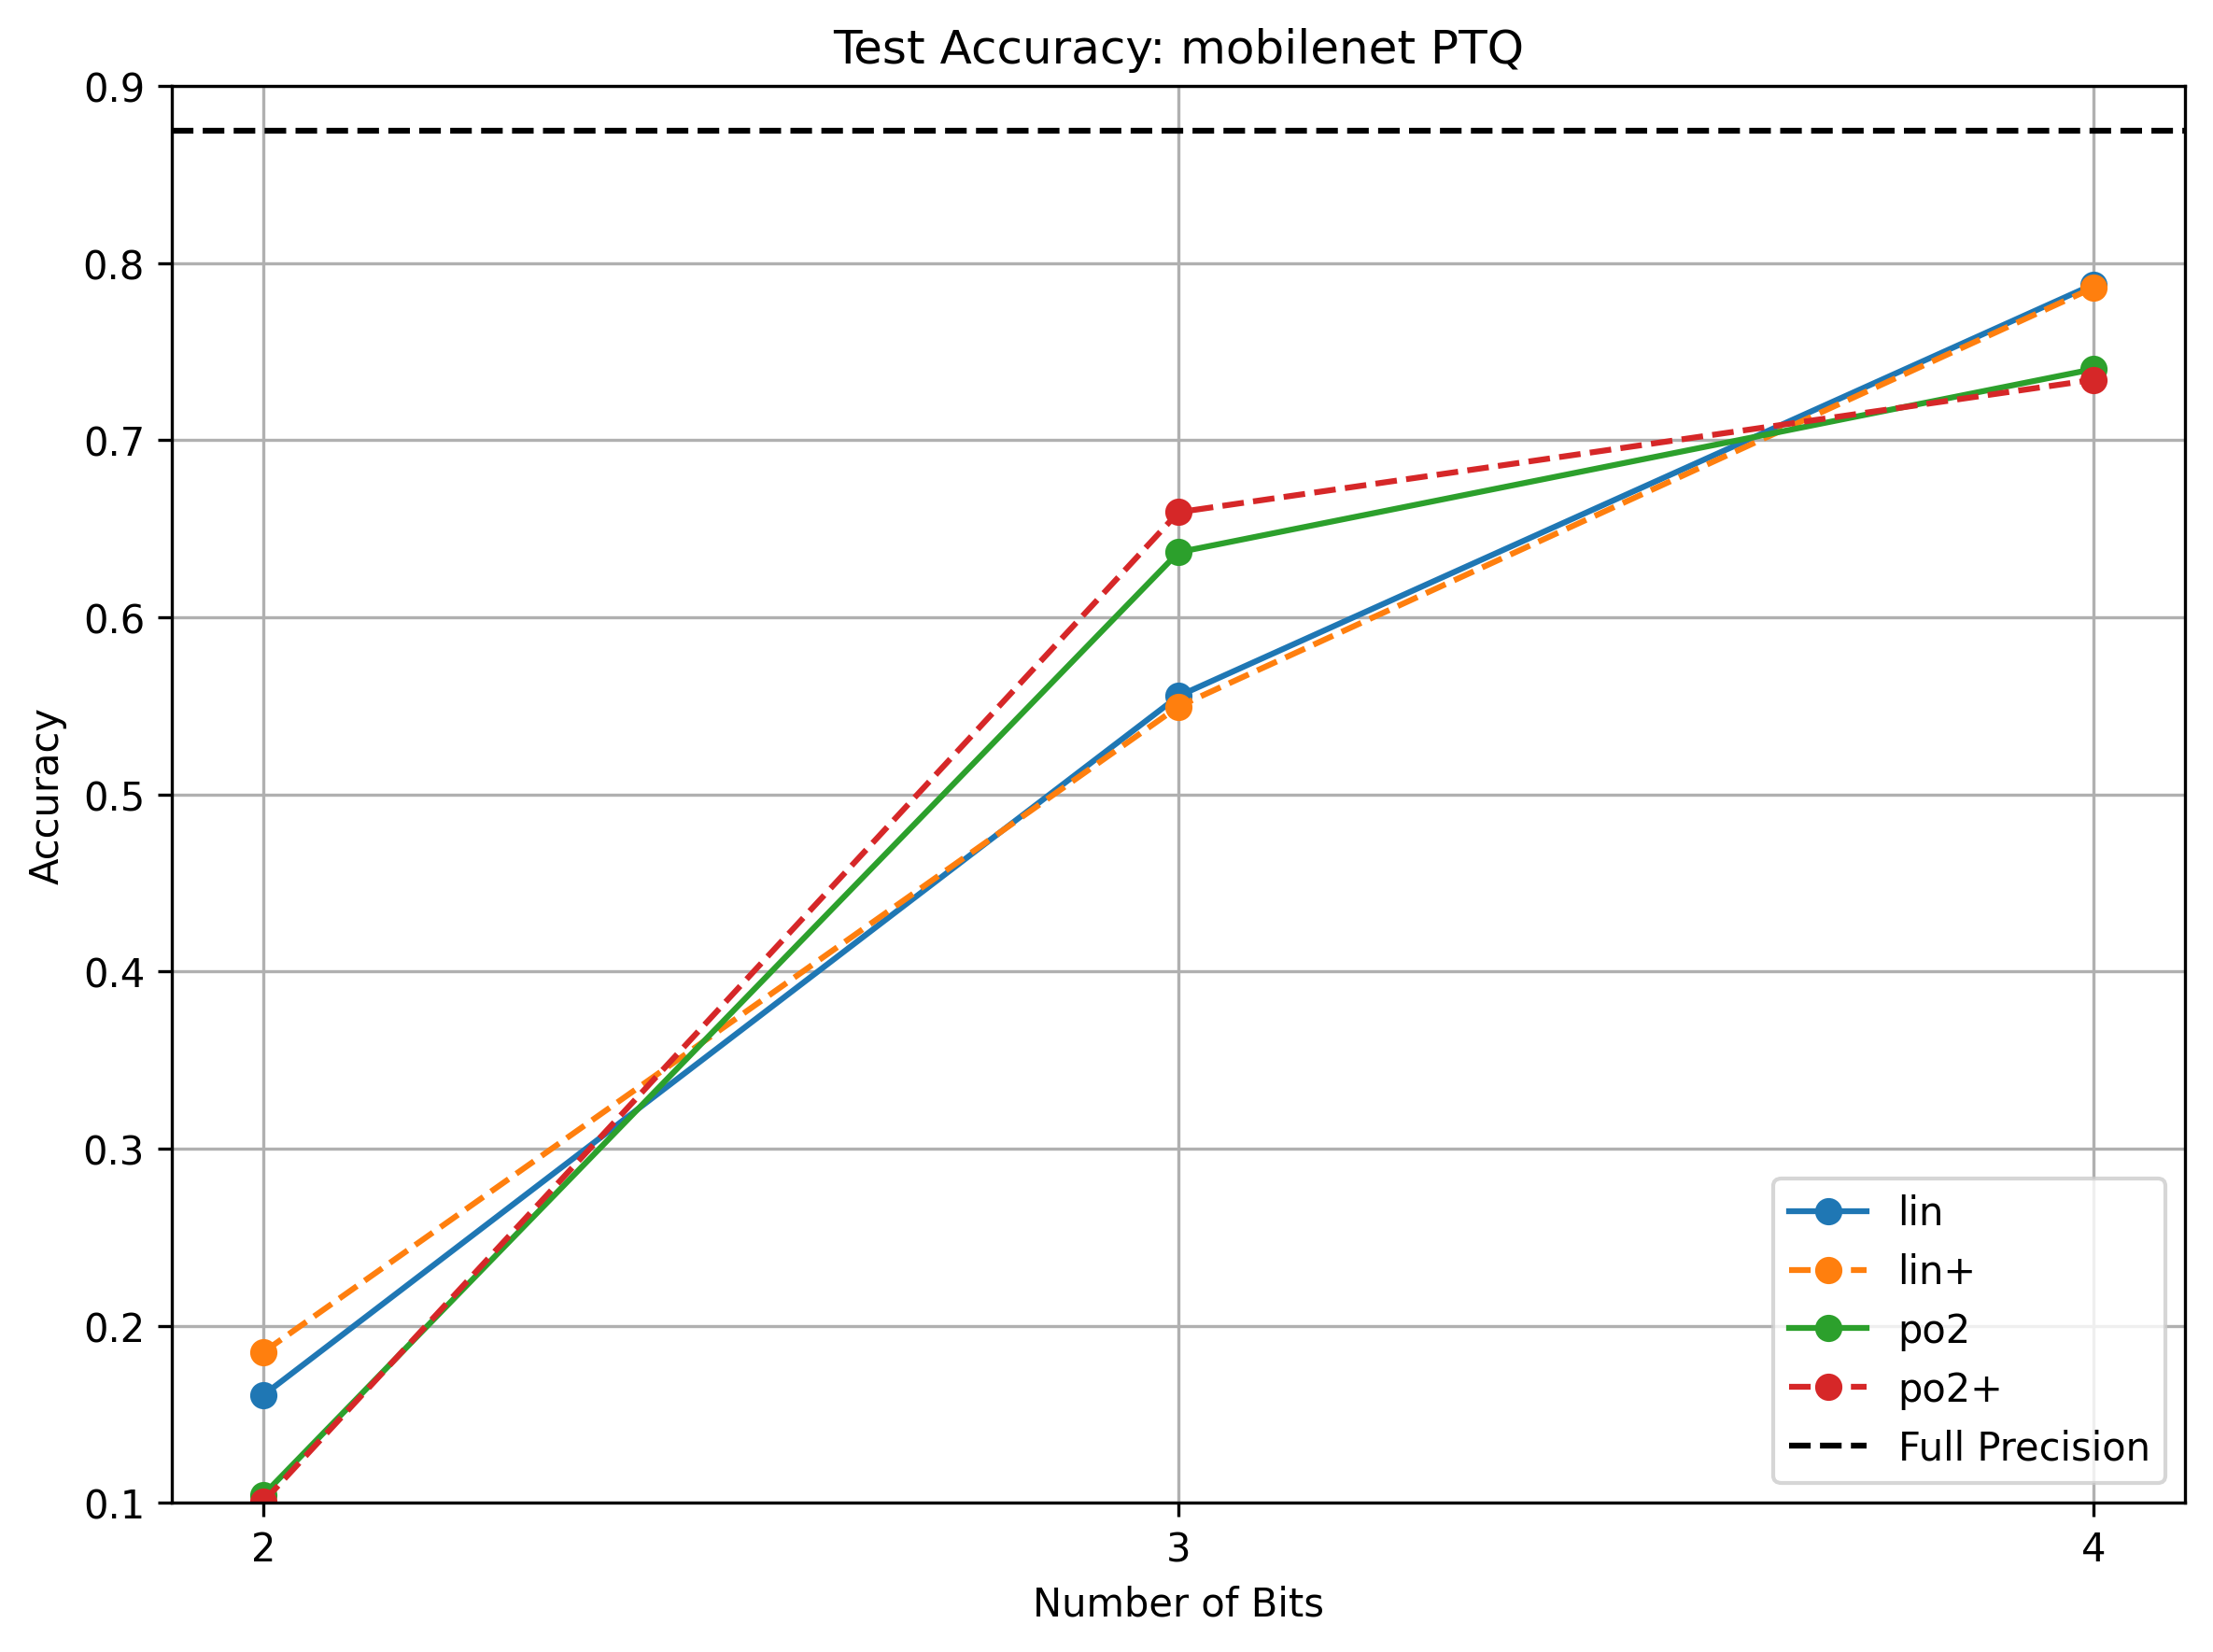

In [196]:
_ = get_results("mobilenet", 0.1, 0.9, qat=False)

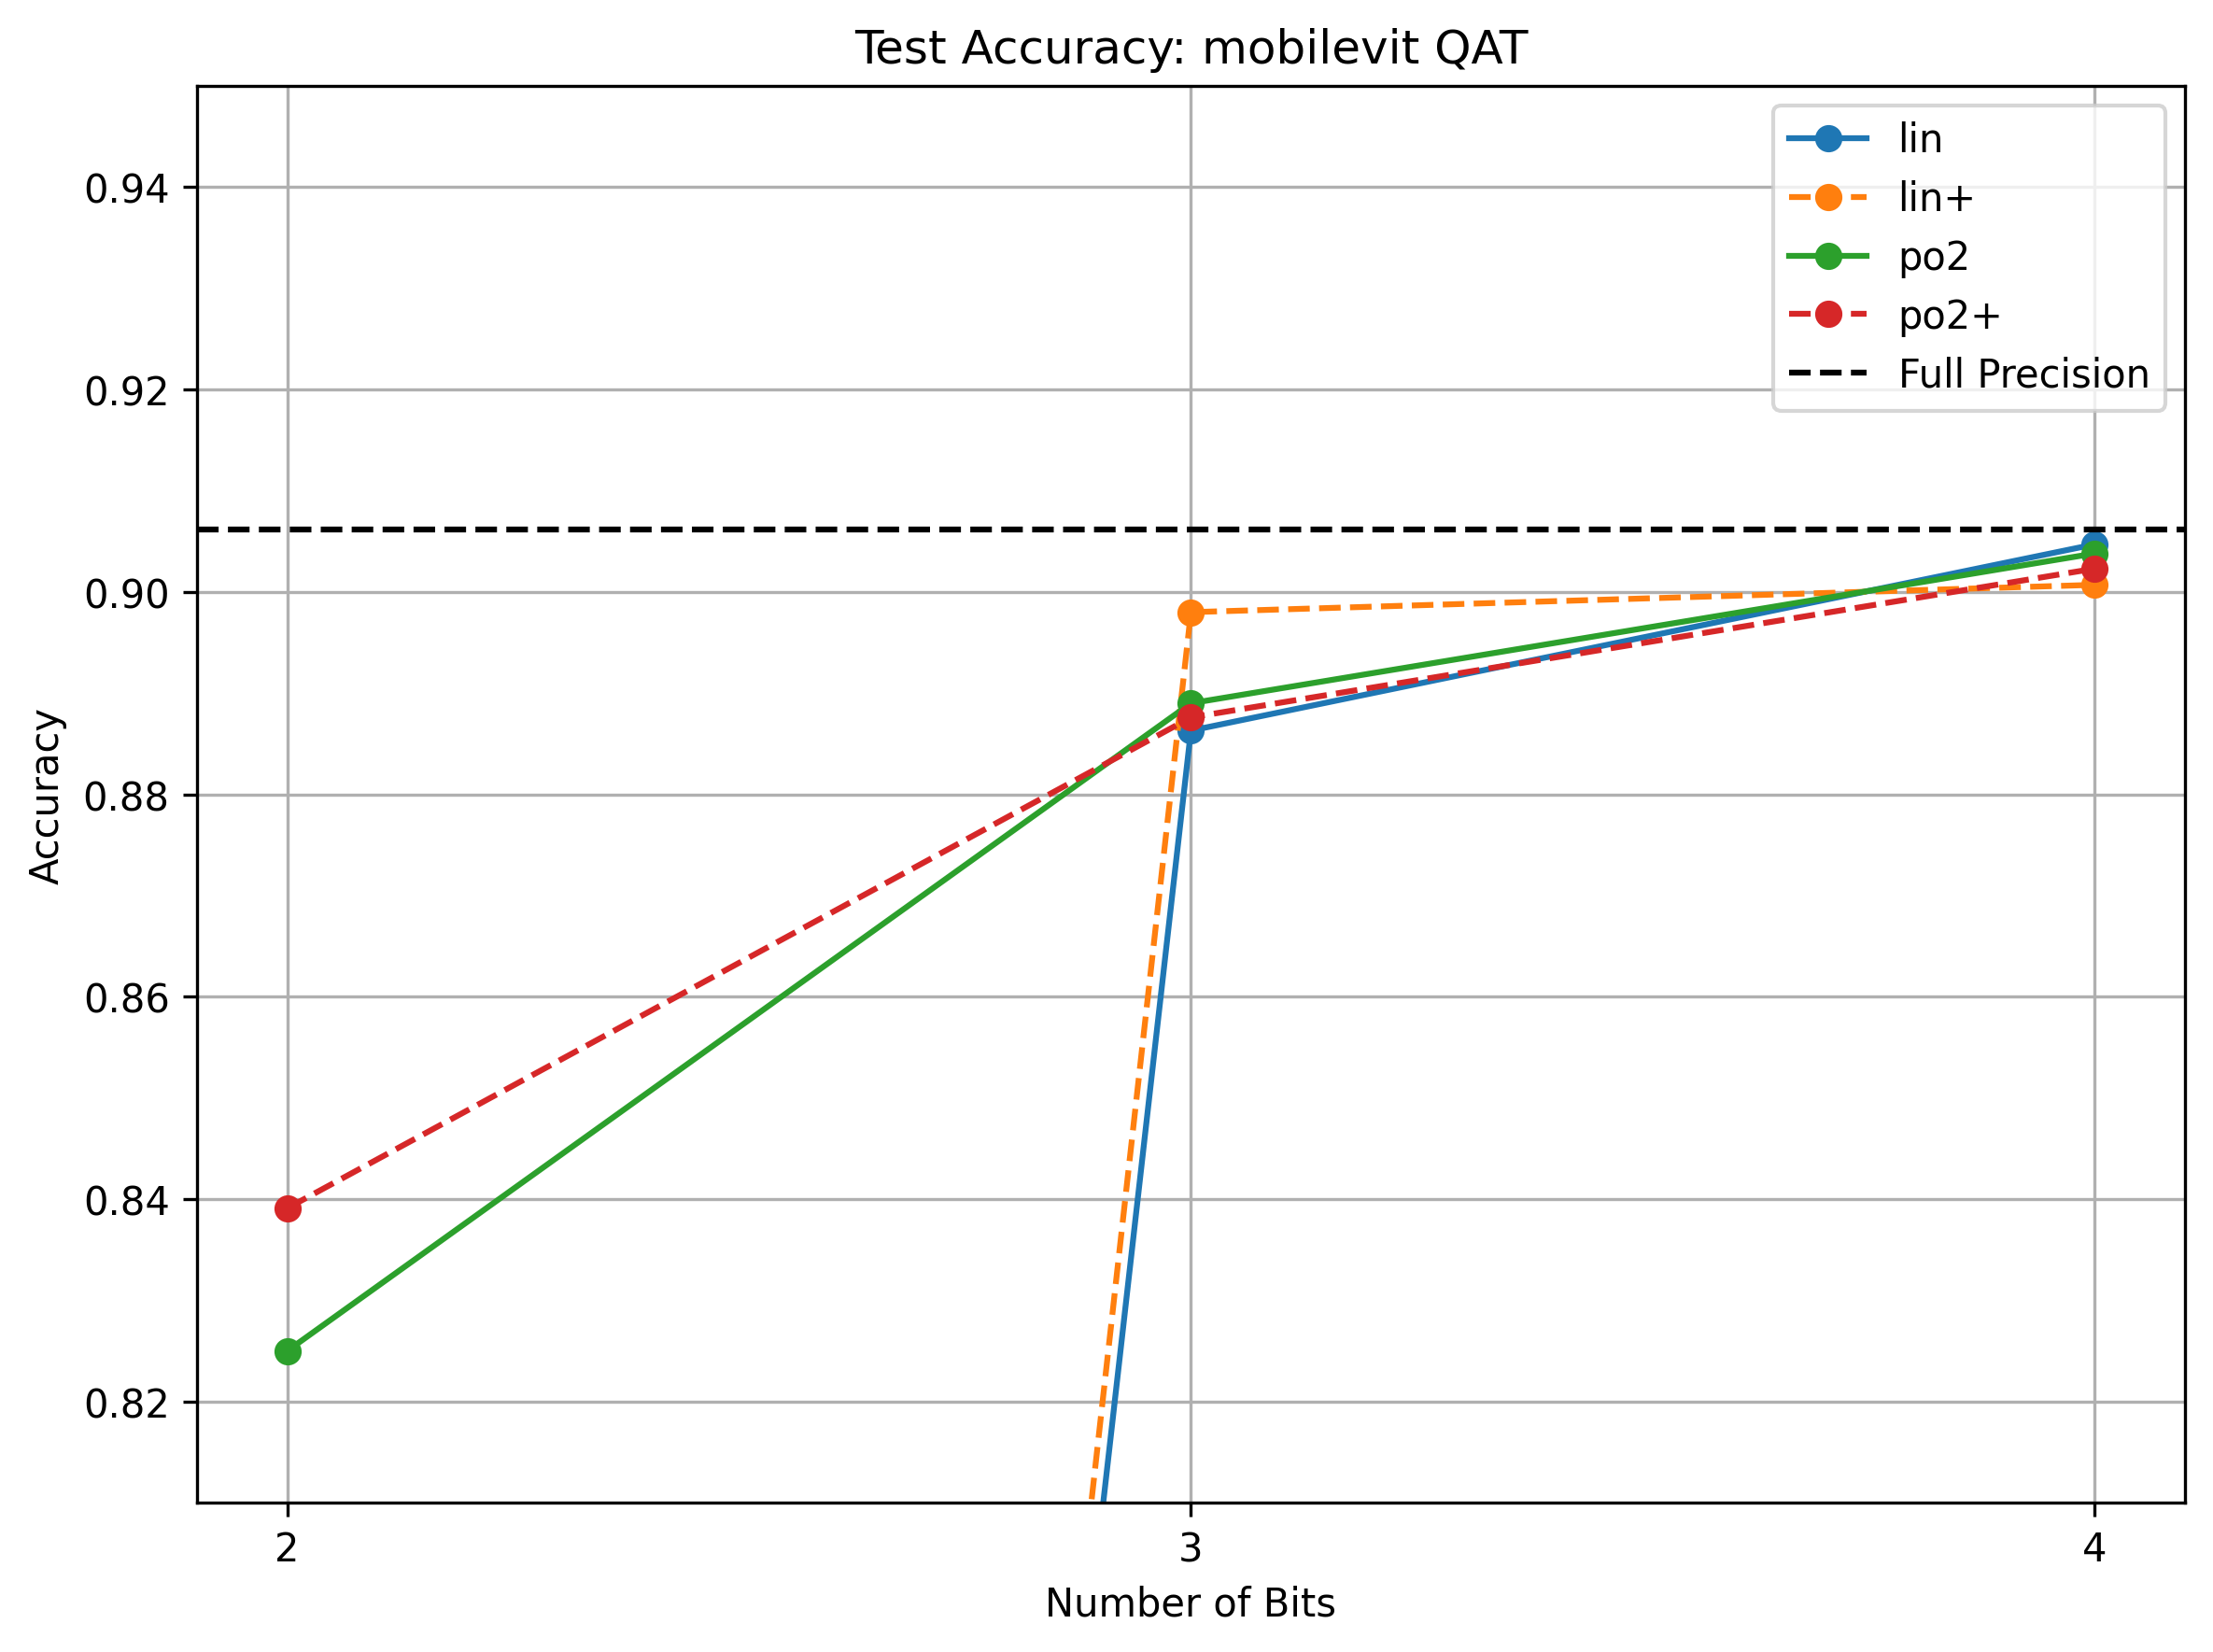

quantizer     lin    lin+  lin+ improvement (%)     po2    po2+  \
type bits                                                         
ptq  2     0.0929  0.1211                 30.36  0.1000  0.1000   
     3     0.5000  0.4822                 -3.56  0.4045  0.5363   
     4     0.8476  0.7838                 -7.53  0.7022  0.7147   
qat  2     0.1000  0.1000                  0.00  0.8250  0.8391   
     3     0.8863  0.8980                  1.32  0.8890  0.8876   
     4     0.9047  0.9007                 -0.44  0.9038  0.9023   

quantizer  po2+ improvement (%)  
type bits                        
ptq  2                     0.00  
     3                    32.58  
     4                     1.78  
qat  2                     1.71  
     3                    -0.16  
     4                    -0.17

In [199]:
get_results("mobilevit", 0.81, 0.95, qat=True)

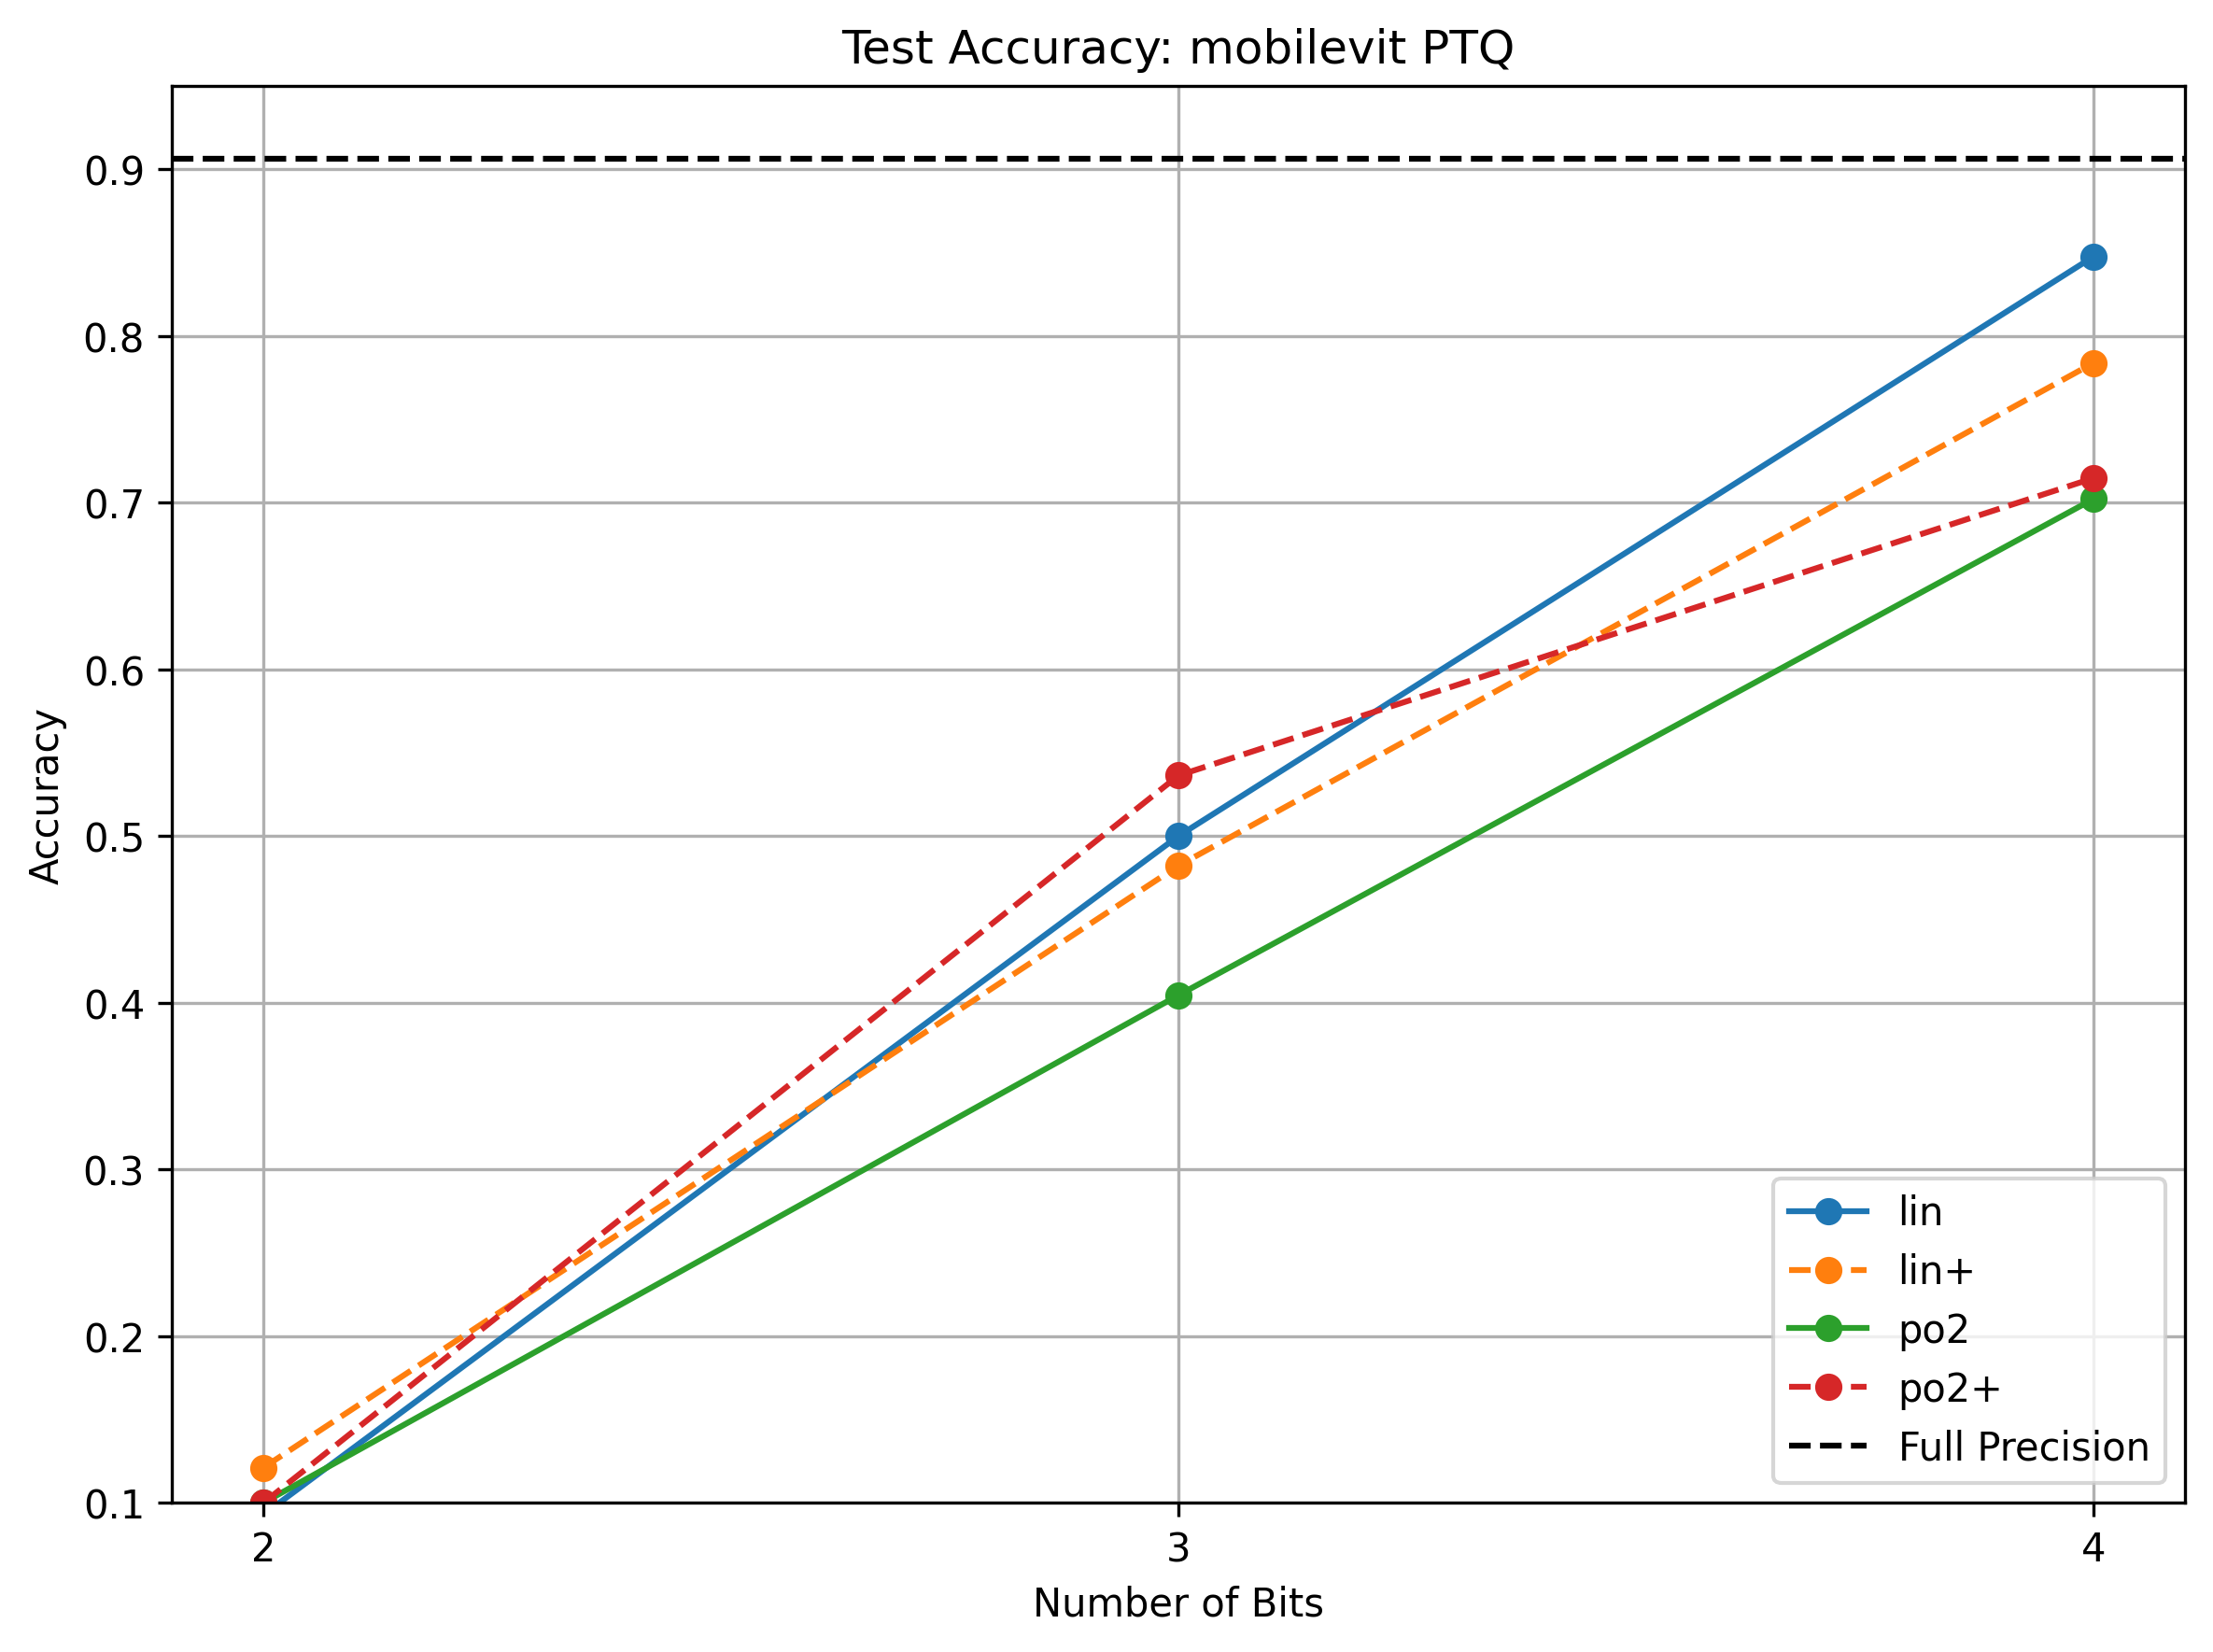

In [200]:
_ = get_results("mobilevit", 0.1, 0.95, qat=False)